# Zona / Sub-Cortical Connectivity

## Table of Contents
* [Modules & Custom Functions](#imports)
* [Subject Demographics](#demographics)
* [Subcortical Analysis](#subcortical_analysis)
    * [Test Dataset](#test_analysis)
    * [Retest Dataset](#retest_analysis)
    * [Test vs Retest](#test_v_retest)
* [In-depth subcortical nodes](#subconn_detail)
* [Pallidothalamic tracts](#pallidothalamic)
* [Ansa Lenticularis (via ft)](#ansa_ft)
* [Installed Packages](#installed_pkgs)

## Modules & Custom Functions <a class="anchor" id="imports"></a>

Every time the notebook is started, the following code cell must be run.

In [1]:
import itertools
import os

import dill
import dipy.io.streamline
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats as stats
import seaborn as sns
from dipy.viz import colormap as cmap
from fury import actor, window
from IPython.display import HTML, clear_output
from joblib import Parallel, delayed
from joblib.pool import has_shareable_memory
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from mne.viz import circular_layout, plot_connectivity_circle as plot_chord
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Set number of processors for multiproccessing
n_proc = 12

# Define a function to handle importing database to avoid rerunning cells
def handle_session(save=False):
    if save:
        print("Saving notebook session")
        dill.dump_session(os.path.realpath("./db/hcp3T_Zona_Connectivity.db"))
    else:
        print("Loading notebook session")
        dill.load_session(os.path.realpath("./db/hcp3T_Zona_Connectivity.db"))


# Pandas settings
pd.set_option("display.max_rows", None)

try:
    handle_session()
except:
    raise FileNotFoundError(
        """No database found - please run the all of the following cells to
    set up custom functions and perform analysis"""
    )

/srv/khan/users/tkai/opt/venv/hcp-subcortical-analysis-_mFvww50-py3.7/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Loading notebook session


In [2]:
# Variables
zona_dir = os.path.realpath("../../data/hcp1200_3T_2")
test_dir = f"{zona_dir}/hcp_test"
retest_dir = f"{zona_dir}/hcp_retest"

In [3]:
# Plot settings
# Color friendly color cycle - gist.github.com/thriveth/8560036
cb_color_cycle = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]

cmap = mpl.cm.get_cmap("viridis")
cmap.set_bad("black")
sns.set(
    style="ticks",
    context="poster",
    rc={
        "image.cmap": "viridis",
        "axes.prop_cycle": plt.cycler(color=cb_color_cycle),
        "font.sans-serif": "Liberation Sans",
        "font.monospace": "Liberation Sans",
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 14,
        "axes.labelweight": "bold",
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    },
)

boxprops = dict(edgecolor="white", alpha=0.5)
whiskerprops = dict(color="black", linestyle="--", alpha=0.5)
capprops = dict(color="black", alpha=0.5)
medianprops = dict(color="white", linewidth=2)
figure_dir = os.path.realpath("./figures")

In [5]:
def compute_dsc(subjid, node1, node2, weighted=False):
    """
    Computes the (weighted) Dice similarity coefficient to assess tract overlap

    INPUTS:
        subjid - ID of subject to assess
        node1 - One ROI, as an integer label, where tract terminates
        node2 - Other ROI, as an interger label, where tract terminates
        weighted - [Optional] Choice of weighted or conventional Dice overlap
    """

    # Load test data
    test_tract = f"{test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tdi/{subjid}_space-dwi_tdi{node1}-{node2}.nii.gz"
    retest_tract = f"{retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tdi/{subjid}_space-dwi_tdi{node1}-{node2}.nii.gz"

    # If tract does exist
    if not os.path.exists(test_tract) or not os.path.exists(retest_tract):
        return np.nan

    # Load data
    test_img = nib.load(test_tract).get_fdata()
    retest_img = nib.load(retest_tract).get_fdata()

    test_bool = np.asarray(test_img, dtype=bool)
    retest_bool = np.asarray(retest_img, dtype=bool)

    overlap = np.logical_and(test_bool, retest_bool)

    # Weighted dice scores
    if weighted:
        # Compute fractions
        test_frac = test_img / test_img.sum()
        retest_frac = retest_img / retest_img.sum()

        overlap = overlap * (test_frac + retest_frac)
        overlap = overlap.sum()
        union = test_frac.sum() + retest_frac.sum()

    # Conventional dice scores
    else:
        overlap = 2 * overlap.sum()
        union = test_bool.sum() + retest_bool.sum()

    dsc = overlap.sum() / union

    return dsc

In [6]:
def make_mat(vals, mat_size):
    """
    Create a connectivity matrix from an array of sorted array of values

    INPUTS:
        vals - sorted array of values to be added to matrix
        mat_size - size of matrix
    """

    mask = ~np.tri(mat_size, k=0, dtype=bool)
    mat = np.zeros((mat_size, mat_size), dtype=np.float32)
    mat[mask] = vals
    mat.T[mask] = vals

    return mat

In [7]:
def compute_dsc_ansa(subjid, hemi, percentile, weighted=False):
    """
    Computes the (weighted) Dice similarity coefficient to assess tract overlap.
    Similar to previous `compute_dsc` function, but specific to the ansa lenticularis.

    INPUTS:
        subjid - ID of subject to assess
        hemi - Hemisphere to assess ('L' or 'R')
        percentile - Choice of threshold to evaluate (tracts are previously threshold by CCI)
        weighted - [Optional] Choice of weighted or conventional Dice overlap
    """

    subjid = subjid[0]

    # Get appropriate nodes
    nodes = "13-69" if hemi == "L" else "14-70"

    # Load test data
    test_tract = f"{test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tdi/{subjid}_space-dwi_hemi-{hemi}_desc-ft_tdi{nodes}_{percentile}.nii.gz"
    retest_tract = f"{retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tdi/{subjid}_space-dwi_hemi-{hemi}_desc-ft_tdi{nodes}_{percentile}.nii.gz"

    try:
        os.system(
            f"tar -xf {test_dir}/derivatives/mrtpipelines_0.1.6/mrtipelines/{subjid}/tdi/{subjid}_tdi-ansa.tar -C {test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tdi --wildcards *{node1}-{node2}_{percntile}.nii.gz"
        )
        os.system(
            f"tar -xf {retest_dir}/derivatives/mrtpipelines_0.1.6/mrtipelines/{subjid}/tdi/{subjid}_tdi-ansa.tar -C {retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tdi --wildcards *{node1}-{node2}_{percentile}.nii.gz"
        )
    except:
        # If tract does exist, clean up directory and return NaN
        if not os.path.exists(test_tract):
            return np.nan
        elif not os.path.exists(retest_tract):
            os.system(
                f"rm {test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tdi/*.nii.gz"
            )
            return np.nan

    # Load test data
    test_img = nib.load(test_tract).get_fdata()
    retest_img = nib.load(retest_tract).get_fdata()

    test_bool = np.asarray(test_img, dtype=bool)
    retest_bool = np.asarray(retest_img, dtype=bool)

    overlap = np.logical_and(test_bool, retest_bool)

    # Weighted dice scores
    if weighted:
        # Compute fractions
        test_frac = test_img / test_img.sum()
        retest_frac = retest_img / retest_img.sum()

        overlap = overlap * (test_frac + retest_frac)
        overlap = overlap.sum()
        union = test_frac.sum() + retest_frac.sum()

    # Conventional dice scores
    else:
        overlap = 2 * overlap.sum()
        union = test_bool.sum() + retest_bool.sum()

    dsc = overlap.sum() / union

    return dsc

In [8]:
def check_hemi(node: int):
    return "Even" if ((node % 2) == 0) else "Odd"

In [9]:
def viz_tract(
    subjid,
    node1=13,
    node2=69,
    roi=None,
    perc=None,
    hemi="L",
    retest=False,
    interactive=False,
    opacity=0.5,
    size=(600, 600),
):
    """
    Visualize tract using `fury`.
    By default, only show the tract from the test dataset

    Eg. Interactive visualization of ansa, passing through 'fl' roi, thresholded at 25th percentile of CCI
    viz_tract('sub-103818', 13, 69, roi='fl', perc=25, retest=True, interactive=True)

    INPUTS:
        subjid - ID of subject to visualize
        node1 - terminal node for tract
        node2 - other terminal node for trat
        roi - region used to mask tractography
        perc - percentile to visualize (25, 50, or 75)
        hemi - hemisphere the tract is in
        retest - overlay retest tractography
        interactive - interactive visualization
        opacity - opacity of tractography
        size - figure window dimensions
    """

    # Select tracts
    if not roi and not perc:
        tract_type = "edge"
        test_tract = f"{test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/edge/{subjid}_space-dwi_desc-from_{node1}-{node2}.tck"
        retest_tract = f"{retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/edge/{subjid}_space-dwi_desc-from_{node1}-{node2}.tck"
    elif roi and not perc:
        tract_type = "masked"
        test_tract = f"{test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/masked/{hemi}/{roi}/{subjid}_space-dwi_hemi-{hemi}_desc-{roi}_{node1}-{node2}.tck"
        retest_tract = f"{retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/masked/{hemi}/{roi}/{subjid}_space-dwi_hemi-{hemi}_desc-{roi}_{node1}-{node2}.tck"
    elif roi and perc:
        tract_type = "cleaned"
        test_tract = f"{test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/cleaned/{subjid}_space-dwi_hemi-{hemi}_desc-{roi}_{node1}-{node2}_{perc}.tck"
        retest_tract = f"{retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/cleaned/{subjid}_space-dwi_hemi-{hemi}_desc-{roi}_{node1}-{node2}_{perc}.tck"
    else:
        print("Something went wrong, try another option...")
        return None

    if not os.path.exists(test_tract):
        try:
            if not roi:
                os.system(
                    f"tar -xf {test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/{subjid}_edge.tar -C {test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography --wildcards *{node1}-{node2}.tck"
                )
            else:
                if tract_type == "masked":
                    os.system(
                        f"tar -xf {test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/{subjid}_masked.tar -C {test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/ --wildcards *{roi}_{node1}-{node2}_{perc}.tck"
                    )
                else:
                    os.system(
                        f"tar -xf {test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/{subjid}_cleaned.tar -C {test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/ --wildcards *{roi}_{node1}-{node2}_{perc}.tck"
                    )
        except:
            print(
                "Tract from test dataset does not exist and may need to be extracted from archives..."
            )
            print(f"Expected tract path: {test_tract}")
            return None

    if not os.path.exists(retest_tract):
        try:
            if not roi:
                os.system(
                    f"tar -xf {retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/{subjid}_edge.tar -C {retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography --wildcards *{node1}-{node2}.tck"
                )
            else:
                if tract_type == "masked":
                    os.system(
                        f"tar -xf {retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/{subjid}_masked.tar -C {retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/ --wildcards *{roi}_{node1}-{node2}_{perc}.tck"
                    )
                else:
                    os.system(
                        f"tar -xf {retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/{subjid}_cleaned.tar -C {retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subjid}/tractography/ --wildcards *{roi}_{node1}-{node2}_{perc}.tck"
                    )
        except:
            print(
                "Tract from retest dataset does not exist and may need to be extracted from archives..."
            )
            print(f"Expected tract path: {retest_tract}")
            return None

        if retest:
            print("Unable to continue with selected options...")
            return None

    # Load tracts
    anat_ref = nib.load(
        f"{test_dir}/{subjid}/anat/{subjid}_acq-procHCP_T1w_brain.nii.gz"
    )
    anat_affine = anat_ref.affine
    test_tck = dipy.io.streamline.load_tractogram(test_tract, anat_ref)
    if retest:
        retest_tck = dipy.io.streamline.load_tractogram(retest_tract, anat_ref)

    # Load ROIs
    subconn_roi = nib.load(
        f"{test_dir}/derivatives/zona_bb_subcortex/{subjid}/anat/{subjid}_space-T1w_desc-ZonaBBSubCorSeg.nii.gz"
    )
    subconn_roi = subconn_roi.get_fdata()

    roi_1 = subconn_roi == node1
    roi_2 = subconn_roi == node2
    surface_color1 = [0, 1, 1]
    surface_color2 = [1, 1, 0]

    # Setup actors & scene
    scene = window.Scene()

    tract_width = 1.5
    if retest:
        test_actor = actor.line(
            test_tck.streamlines,
            (0, 1, 0),
            opacity=opacity,
            linewidth=tract_width,
            fake_tube=True,
        )
        retest_actor = actor.line(
            retest_tck.streamlines,
            (1, 0, 0),
            opacity=opacity,
            linewidth=tract_width,
            fake_tube=True,
        )
    else:
        test_actor = actor.line(
            test_tck.streamlines,
            (0, 1, 0),
            linewidth=tract_width,
            fake_tube=True,
            opacity=opacity,
        )

    roi1_actor = actor.contour_from_roi(roi_1, anat_affine, surface_color1, 1)
    roi2_actor = actor.contour_from_roi(roi_2, anat_affine, surface_color2, 1)

    # Set coronal anterior
    if interactive:
        scene.yaw(90)
        scene.pitch(-90)
        scene.add(test_actor)
        if retest:
            scene.add(retest_actor)
        scene.add(roi1_actor)
        scene.add(roi2_actor)
        window.show(scene, size=size)
    else:
        scene.yaw(90)
        scene.roll(180)
        scene.pitch(-90)
        scene.add(test_actor)
        scene.add(roi1_actor)
        scene.add(roi2_actor)
        scene.reset_camera()
        test_scene = window.snapshot(scene, size=size, offscreen=not (interactive))

        if retest:
            scene.add(retest_actor)
            overlay_scene = window.snapshot(
                scene, size=size, offscreen=not (interactive)
            )
            scene.rm(test_actor)
            retest_scene = window.snapshot(
                scene, size=size, offscreen=not (interactive)
            )

            scenes = [test_scene, retest_scene, overlay_scene]
            scene_titles = ["Test tract", "Retest tract", "Overlay"]

            fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))
            for ix, (scene, title) in enumerate(zip(scenes, scene_titles)):
                axes[ix].imshow(scene)
                axes[ix].axis("off")
                axes[ix].set_title(title, size=12)

        else:
            fig, axes = plt.subplots(1, 1, figsize=(3, 3.5))
            axes.imshow(test_scene)
            axes.axis("off")
            axes.set_title("Test tract", size=12)

        fig.suptitle("Coronal anterior view", size=14)

    os.system(f"rm {test_tract}")
    if retest:
        os.system(f"rm {retest_tract}")

In [10]:
def plot_subconn_density_scatter(
    df, node1, node2, fig=None, ax=None, lims=None, fname=None
):
    """
    Scatterplot of test vs retest tract density (log transformed). If
    intrahemispheric node, will automatically plot same nodes in
    opposite hemisphere

    INPUTS:
        df - dataframe containing information tract density info
        node1 - terminal node for tract
        node2 - other terminal node for tract
        fig - figure to draw on
        ax - axes to draw on
        lims - limits of xaxis; default: set to .05 below/above the min/max
        fname - file name to save figure (please include directory)
    """
    _intra = False

    # Grab data
    nodes = f"{node1}-{node2}"
    if np.unique(df[df["Nodes"] == nodes]["Hemi"])[0] == "L":
        nodes_opp = f"{node1 + 1}-{node2 + 1}"
        _intra = True
    elif np.unique(df[df["Nodes"] == nodes]["Hemi"])[0] == "R":
        nodes_opp = f"{node1 - 1}-{node2 - 1}"
        _intra = True

    if _intra:
        df = pd.concat(
            [df[df["Nodes"] == nodes], df[df["Nodes"] == nodes_opp]], sort=False
        )
    else:
        df = df[df["Nodes"] == nodes]

    pstats = stats.spearmanr(df["Test Density [log10]"], df["Retest Density [log10]"])

    # Plots
    if not fig:
        fig, ax = plt.subplots(1, 1, figsize=(5, 7))

    sns.scatterplot(
        data=df,
        x="Test Density [log10]",
        y="Retest Density [log10]",
        hue="Hemi",
        ax=ax,
        s=30,
        alpha=0.7,
    )

    sns.regplot(
        data=df,
        x="Test Density [log10]",
        y="Retest Density [log10]",
        ax=ax,
        scatter=False,
        color="black",
        ci=95,
        line_kws={"lw": 2, "linestyle": "--", "alpha": 0.5},
    )

    if not lims:
        lims = [
            round(
                np.min(
                    [
                        df["Test Density [log10]"].min(),
                        df["Retest Density [log10]"].min(),
                    ]
                ),
                2,
            ),
            round(
                np.max(
                    [
                        df["Test Density [log10]"].max(),
                        df["Retest Density [log10]"].max(),
                    ]
                ),
                2,
            ),
        ]
        lims = [lims[0] - 0.05, lims[1] + 0.05]

    # Plot params
    ax.set_xlim(lims)
    ax.set_xticks(np.arange(lims[0], lims[1], 0.2))
    ax.set_ylim(lims)
    ax.set_yticks(np.arange(lims[0], lims[1], 0.2))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    connectivity = f'{parcellation_map[parcellation_map["Label"] == node1]["Nuclei"].values[0]} - {parcellation_map[parcellation_map["Label"] == node2]["Nuclei"].values[0]}'
    if _intra:
        connectivity = f'{parcellation_map[parcellation_map["Label"] == node1]["Nuclei"].values[0].split(None,1)[1]} - {parcellation_map[parcellation_map["Label"] == node2]["Nuclei"].values[0].split(None,1)[1]}'
        handles, legend = ax.get_legend_handles_labels()
        ax.legend(handles[:2], ["LH", "RH"], fontsize=12, markerscale=0.5)
    else:
        ax.get_legend().remove()

    ax.set_title(connectivity, fontsize=14, fontweight="bold")
    ax.text(
        lims[0] + 0.05,
        lims[1] - 0.2,
        s=f"$\\rho$ = {pstats[0]:.3f}, \n$p_{{{'uncorr'}}}$ = {pstats[1]:.3g}",
        size=12,
    )
    ax.set_xlabel("Avg. Test Tract Density [log(AFD/mm)]")
    ax.set_ylabel("Avg. Retest Tract Density [log(AFD/mm)]")

    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight", facecolor="white")

    plt.show()
    plt.close()

In [11]:
def plot_subconn_density_box(
    df, node1, node2, fig=None, ax=None, lims=None, fname=None
):
    """
    Boxplots of test vs retest tract density. If
    intrahemispheric node, will automatically plot same nodes in
    opposite hemisphere

    INPUTS:
        df - dataframe containing information tract density info
        node1 - terminal node for tract
        node2 - other terminal node for tract
        fig - figure to draw on
        ax - axes to draw on
        lims - limits of xaxis; default: set to .05 below/above the min/max
        fname - file name to save figure (please include directory)
    """
    _intra = False

    # Grab data
    nodes = f"{node1}-{node2}"
    if np.unique(df[df["Nodes"] == nodes]["Hemi"])[0] == "L":
        nodes_opp = f"{node1 + 1}-{node2 + 1}"
        _intra = True
    elif np.unique(df[df["Nodes"] == nodes]["Hemi"])[0] == "R":
        nodes_opp = f"{node1 - 1}-{node2 - 1}"
        _intra = True

    if _intra:
        df = pd.concat(
            [df[df["Nodes"] == nodes], df[df["Nodes"] == nodes_opp]], sort=False
        )
    else:
        df = df[df["Nodes"] == nodes]

    if not fig:
        fig, ax = plt.subplots(1, 1, figsize=(5, 7))

    sns.boxplot(
        data=df,
        x="Hemi",
        y="Density [log]",
        hue="Dataset",
        dodge=True,
        ax=ax,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        showfliers=False,
        whis=0.95,
    )

    sns.swarmplot(
        data=df,
        x="Hemi",
        y=f"Density [log]",
        hue="Dataset",
        ax=ax,
        color="black",
        alpha=0.5,
        dodge=True,
        size=4,
    )

    if not lims:
        lims = [
            round(df["Density [log]"].min(), 2) - 0.05,
            round(df["Density [log]"].max(), 2) + 0.05,
        ]

    # Plot parameters
    ax.set_ylim(lims)
    ax.set_yticks(np.arange(lims[0], lims[1], 0.2))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_ylabel("Tract Density [log(AFD/mm)]")

    connectivity = f'{parcellation_map[parcellation_map["Label"] == node1]["Nuclei"].values[0]} - {parcellation_map[parcellation_map["Label"] == node2]["Nuclei"].values[0]}'
    if _intra:
        connectivity = f'{parcellation_map[parcellation_map["Label"] == node1]["Nuclei"].values[0].split(None,1)[1]} - {parcellation_map[parcellation_map["Label"] == node2]["Nuclei"].values[0].split(None,1)[1]}'
        ax.set_xticklabels(["Left", "Right"])
        ax.set_xlabel("Hemisphere")
    else:
        ax.tick_params(bottom=False)
        ax.set_xticklabels([])
        ax.set_xlabel("")

    ax.set_title(connectivity, fontsize=14, fontweight="bold")
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Test", "Retest"], ncol=1)

    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight", facecolor="white")

    plt.show()
    plt.close()

In [12]:
def plot_subconn_density_change(
    df, node1, node2, fig=None, ax=None, lims=None, fname=None
):
    """
    Boxplot of test vs retest tract density percent change. If
    intrahemispheric node, will automatically plot same nodes in
    opposite hemisphere

    INPUTS:
        df - dataframe containing information tract density info
        node1 - terminal node for tract
        node2 - other terminal node for tract
        fig - figure to draw on
        ax - axes to draw on
        lims - limits of xaxis; default: set to .05 below/above the min/max
        fname - file name to save figure (please include directory)
    """

    _intra = False

    # Grab data
    nodes = f"{node1}-{node2}"
    if np.unique(df[df["Nodes"] == nodes]["Hemi"])[0] == "L":
        nodes_opp = f"{node1 + 1}-{node2 + 1}"
        _intra = True
    elif np.unique(df[df["Nodes"] == nodes]["Hemi"])[0] == "R":
        nodes_opp = f"{node1 - 1}-{node2 - 1}"
        _intra = True

    if _intra:
        df = pd.concat(
            [df[df["Nodes"] == nodes], df[df["Nodes"] == nodes_opp]], sort=False
        )
    else:
        df = df[df["Nodes"] == nodes]

    if not fig:
        fig, ax = plt.subplots(1, 1, figsize=(5, 7))

    # Plot hemispheric difference
    sns.boxplot(
        data=df,
        x="Hemi",
        y=f"Percent Change",
        dodge=True,
        ax=ax,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        showfliers=False,
        whis=0.95,
    )

    sns.swarmplot(
        data=df,
        x="Hemi",
        y=f"Percent Change",
        ax=ax,
        color="black",
        alpha=0.5,
        dodge=True,
        size=4,
    )

    if not lims:
        lims = [
            round(df["Percent Change"].min(), -1),
            round(df["Percent Change"].max(), -1),
        ]

    # Plot parameters
    ax.set_ylim(lims)
    ax.set_yticks(np.arange(lims[0], lims[1], 25))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_ylabel("Percent change [%]")

    connectivity = f'{parcellation_map[parcellation_map["Label"] == node1]["Nuclei"].values[0]} - {parcellation_map[parcellation_map["Label"] == node2]["Nuclei"].values[0]}'
    if _intra:
        connectivity = f'{parcellation_map[parcellation_map["Label"] == node1]["Nuclei"].values[0].split(None,1)[1]} - {parcellation_map[parcellation_map["Label"] == node2]["Nuclei"].values[0].split(None,1)[1]}'
        ax.set_xticklabels(["Left", "Right"])
        ax.set_xlabel("Hemisphere")
    else:
        ax.tick_params(bottom=False)
        ax.set_xticklabels([])
        ax.set_xlabel("")

    ax.set_title(connectivity, fontsize=14, fontweight="bold")

    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight", facecolor="white")

    plt.show()
    plt.close()

In [13]:
def plot_subconn_overlap(df, node1, node2, fig=None, ax=None, lims=None, fname=None):
    """
    Boxplot of test vs retest tract overlap. If intrahemispheric node,
    will automatically plot same nodes in opposite hemisphere

    INPUTS:
        df - dataframe containing information tract density info
        node1 - terminal node for tract
        node2 - other terminal node for tract
        fig - figure to draw on
        ax - axes to draw on
        lims - limits of xaxis; default: set to .05 below/above the min/max
        fname - file name to save figure (please include directory)
    """

    _intra = False

    # Grab data
    nodes = f"{node1}-{node2}"
    if np.unique(df[df["Nodes"] == nodes]["Hemi"])[0] == "L":
        nodes_opp = f"{node1 + 1}-{node2 + 1}"
        _intra = True
    elif np.unique(df[df["Nodes"] == nodes]["Hemi"])[0] == "R":
        nodes_opp = f"{node1 - 1}-{node2 - 1}"
        _intra = True

    if _intra:
        df = pd.concat(
            [df[df["Nodes"] == nodes], df[df["Nodes"] == nodes_opp]], sort=False
        )
    else:
        df = df[df["Nodes"] == nodes]

    if not fig:
        fig, ax = plt.subplots(1, 1, figsize=(5, 7))

    # Plot hemispheric difference
    sns.boxplot(
        data=df,
        x="Hemi",
        y=f"Tract Overlap (wDSC)",
        dodge=True,
        ax=ax,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        showfliers=False,
        whis=0.95,
    )

    sns.swarmplot(
        data=df,
        x="Hemi",
        y=f"Tract Overlap (wDSC)",
        ax=ax,
        color="black",
        alpha=0.5,
        dodge=True,
        size=4,
    )

    if not lims:
        lims = [
            round(df["Tract Overlap (wDSC)"].min(), 1) - 0.025,
            round(df["Tract Overlap (wDSC)"].max(), 1) + 0.025,
        ]

    # Plot parameters
    ax.set_ylim(lims)
    ax.set_yticks(np.arange(lims[0] - 0.05, lims[1] + 0.05), 10)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_ylabel("wDSC")

    connectivity = f'{parcellation_map[parcellation_map["Label"] == node1]["Nuclei"].values[0]} - {parcellation_map[parcellation_map["Label"] == node2]["Nuclei"].values[0]}'
    if _intra:
        connectivity = f'{parcellation_map[parcellation_map["Label"] == node1]["Nuclei"].values[0].split(None,1)[1]} - {parcellation_map[parcellation_map["Label"] == node2]["Nuclei"].values[0].split(None,1)[1]}'
        ax.set_xticklabels(["Left", "Right"])
        ax.set_xlabel("Hemisphere")
    else:
        ax.tick_params(bottom=False)
        ax.set_xticklabels([])
        ax.set_xlabel("")

    ax.set_title(connectivity, fontsize=14, fontweight="bold")

    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight", facecolor="white")

    plt.show()
    plt.close()

In [14]:
def plot_subconn_relationship(
    df, node1, node2, fig=None, ax=None, ylims=None, xlims=None, fname=None
):
    """
    Regression plot showing relationship between wDSC and tract density [log].
    If intrahemispheric node, will automatically plot same nodes in opposite
    hemisphere

    INPUTS:
        df - dataframe containing information tract density info
        node1 - terminal node for tract
        node2 - other terminal node for tract
        fig - figure to draw on
        ax - axes to draw on
        lims - limits of xaxis; default: set to .05 below/above the min/max
        fname - file name to save figure (please include directory)
    """

    _intra = False

    # Grab data
    nodes = f"{node1}-{node2}"
    if np.unique(df[df["Nodes"] == nodes]["Hemi"])[0] == "L":
        nodes_opp = f"{node1 + 1}-{node2 + 1}"
        _intra = True
    elif np.unique(df[df["Nodes"] == nodes]["Hemi"])[0] == "R":
        nodes_opp = f"{node1 - 1}-{node2 - 1}"
        _intra = True

    if _intra:
        df = pd.concat(
            [df[df["Nodes"] == nodes], df[df["Nodes"] == nodes_opp]], sort=False
        )
    else:
        df = df[df["Nodes"] == nodes]

    pstats = stats.spearmanr(df["Avg Density [log10]"], df["Tract Overlap (wDSC)"])

    if not fig:
        fig, ax = plt.subplots(1, 1, figsize=(5, 7))

    # Plot regplot
    sns.scatterplot(
        data=df,
        x="Avg Density [log10]",
        y="Tract Overlap (wDSC)",
        hue="Hemi",
        ax=ax,
        s=30,
        alpha=0.7,
    )

    sns.regplot(
        data=df,
        x="Avg Density [log10]",
        y="Tract Overlap (wDSC)",
        ax=ax,
        scatter=False,
        color="black",
        ci=95,
        line_kws={"lw": 2, "linestyle": "--", "alpha": 0.5},
    )

    if not xlims:
        xlims = [
            round(df["Avg Density [log10]"].min(), 1) - 0.1,
            round(df["Avg Density [log10]"].max(), 1) + 0.1,
        ]

    if not ylims:
        ylims = [
            round(df["Tract Overlap (wDSC)"].min(), 1) - 0.025,
            round(df["Tract Overlap (wDSC)"].max(), 1) + 0.025,
        ]

    # Plot parameters
    ax.set_xlim(xlims)
    ax.set_xticks(np.arange(xlims[0], xlims[1], 0.2))
    ax.set_ylim(ylims)
    ax.set_yticks(np.arange(ylims[0] - 0.05, ylims[1] + 0.05), 10)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Avg. Tract Density [log10]")
    ax.set_ylabel("wDSC")

    connectivity = f'{parcellation_map[parcellation_map["Label"] == node1]["Nuclei"].values[0]} - {parcellation_map[parcellation_map["Label"] == node2]["Nuclei"].values[0]}'
    if _intra:
        connectivity = f'{parcellation_map[parcellation_map["Label"] == node1]["Nuclei"].values[0].split(None,1)[1]} - {parcellation_map[parcellation_map["Label"] == node2]["Nuclei"].values[0].split(None,1)[1]}'
        handles, legend = ax.get_legend_handles_labels()
        ax.legend(handles[:2], ["LH", "RH"], fontsize=12, markerscale=0.5)
    else:
        ax.get_legend().remove()

    ax.set_title(connectivity, fontsize=14, fontweight="bold")
    ax.text(
        xlims[0] + 0.01,
        ylims[1] - 0.125,
        s=f"$\\rho$ = {pstats[0]:.3f}, \n$p_{{{'uncorr'}}}$ = {pstats[1]:.3g}",
        size=12,
    )

    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight", facecolor="white")

    plt.show()
    plt.close()

In [32]:
def connectivity_summary(
    node1,
    node2,
    df_subconn=df_subconn,
    df_subconn_intersession=df_subconn_intersession,
    df_subconn_intrasession=df_subconn_intrasession,
):
    """
    Print summary for nodal connectivity. Prints a full summary
    for intrahemispheric nodes - for interhemispheric
    connectivity, only the intersession summary is printed.

    INPUTS:
        node1 - terminal node for tract
        node2 - other terminal node for tract
        df_subconn - dataframe with subject connectivity info
        df_subconn_intersession - dataframe with session comparisons
        df_subconn_intrasession - dataframe with hemispheric comparisons
    """

    nodes = f"{node1}-{node2}"
    avg_df_subconn = df_subconn[df_subconn["Nodes"] == nodes].mean()

    print(
        f"""Average values for {node1}-{node2}:
    Test Density \t\t{avg_df_subconn["Test Density"]}
    Retest Density \t\t{avg_df_subconn["Retest Density"]}
    Percent Change \t\t{avg_df_subconn["Percent Change"]}
    Tract Overlap \t\t{avg_df_subconn["Tract Overlap (wDSC)"]}\n"""
    )
    if check_hemi(node1) == check_hemi(node2):
        if check_hemi(node1) == "Odd":
            nodes = f"{node1+1}-{node2+1}"
        else:
            nodes = f"{node1-1}-{node2-1}"
        avg_df_subconn = df_subconn[df_subconn["Nodes"] == nodes].mean()
        print(
            f"""Average values for {nodes}:
    Test Density \t\t{avg_df_subconn["Test Density"]}
    Retest Density \t\t{avg_df_subconn["Retest Density"]}
    Percent Change \t\t{avg_df_subconn["Percent Change"]}
    Tract Overlap \t\t{avg_df_subconn["Tract Overlap (wDSC)"]}\n"""
        )

    print(
        f"""Intersession tract density (test vs retest): 
    t-stat \t\t\t{df_subconn_intersession[df_subconn_intersession["Nodes"] == nodes]["t-stat"].values[0]}
    Corrected p-val \t\t{df_subconn_intersession[df_subconn_intersession["Nodes"] == nodes]["t-pval (fdr)"].values[0]}\n"""
    )

    if check_hemi(node1) == check_hemi(node2):
        if check_hemi(node1) == "Odd":
            nodes = f"{node1}-{node2}"
        else:
            nodes = f"{node1-1}-{node2-1}"
        print(
            f"""Intrasession tract density (lh vs rh):
    Test t-stat \t\t{df_subconn_intrasession[df_subconn_intrasession["Nodes"] == nodes]["t-stat [Test]"].values[0]}
    Test corrected p-val \t{df_subconn_intrasession[df_subconn_intrasession["Nodes"] == nodes]["t-pval (fdr) [Test]"].values[0]}
    Retest t-stat \t\t{df_subconn_intrasession[df_subconn_intrasession["Nodes"] == nodes]["t-stat [Retest]"].values[0]}
    Retest corrected p-val \t{df_subconn_intrasession[df_subconn_intrasession["Nodes"] == nodes]["t-pval (fdr) [Retest]"].values[0]}"""
        )

In [15]:
# Scale 3D Plot
from mpl_toolkits.mplot3d.axes3d import Axes3D

def short_proj(ax, x_scale=1., y_scale=1., z_scale=1.):
    scale = np.diag([x_scale, y_scale, z_scale, 1.])
    scale = scale / scale.max()
    scale[3, 3] = 1.
    
    return np.dot(Axes3D.get_proj(ax), scale)

## Demographics <a class="anchor" id="demographics"></a>

In [16]:
demographics_df = pd.read_csv(f"{zona_dir}/demographics.csv")

# Subjects with different acquisitions between sessions: 601127, 192439, 137128, 135528, 169343, 151526, 660951
drop_subj = [601127, 192439, 137128, 135528, 169343, 151526, 660951, 662551]
demographics_df = demographics_df[~demographics_df["Subject"].isin(drop_subj)].filter(["Subject", "Gender", "Age"])
print(f"No. of subjects with matching acquistions: {len(demographics_df)}")
demographics_df

No. of subjects with matching acquistions: 37


Subject Gender    Age
0    103818      F  31-35
1    105923      F  31-35
2    111312      F  31-35
3    114823      F  31-35
4    115320      F  31-35
5    122317      M  31-35
6    125525      F  31-35
7    130518      F  31-35
10   139839      M  26-30
11   143325      F  31-35
12   144226      F  31-35
13   146129      M  22-25
14   149337      M  31-35
15   149741      M  26-30
17   158035      F  26-30
19   172332      F  26-30
20   175439      F  31-35
21   177746      F  26-30
22   185442      M  22-25
23   187547      F  31-35
25   194140      F  26-30
26   195041      F  31-35
27   200109      F  31-35
28   200614      F  31-35
29   204521      F  31-35
30   250427      F  31-35
31   287248      F  26-30
32   341834      M  26-30
33   433839      M  26-30
34   562345      F  31-35
35   599671      M  26-30
37   627549      F  31-35
40   783462      M  22-25
41   859671      F  31-35
42   861456      F  31-35
43   877168      F  31-35
44   917255      M  31-35

## Parcellation mapping

List is split into two cells to be able to show full list

In [20]:
parcellation_map = pd.read_csv(
    f"{test_dir}/derivatives/zona_bb_subcortex/code/subcortical-labels.csv"
)

# Grab indices to be evaluated (core network structures)
# Indices for thalamic labels
left_thal = [34, 36, 40, 42, 46, 50, 56, 68]
right_thal = [label+1 for label in left_thal]

# Indices for non-thalamic labels; ignore hippocampus
left_nonthal = [2, 4, 6, 8, 10, 12, 18]
right_nonthal = [label+1 for label in left_nonthal]

# Reindex list
reindex_list = list(
    np.concatenate([left_nonthal, left_thal, right_nonthal, right_thal])
)

# Drop hippocampal labels
parcellation_map = parcellation_map.filter(items=reindex_list, axis=0)
parcellation_map

Label   Hemi                                            Nuclei      Abbrev
2       3   left                             left substantia nigra        L SN
4       5   left                          left subthalamic nucleus       L STN
6       7   left                                      left caudate       L Cau
8       9   left                                      left putamen       L Put
10     11   left                      left globus pallidus externa       L GPe
12     13   left                      left globus pallidus interna       L GPi
18     19   left                                     left amygdala       L Amy
34     35   left                        left thalamus centromedian   L Thal CM
36     37   left            left thalamus ventral lateral anterior  L Thal VLa
40     41   left    left thalamus mediodorsal medial magnocellular  L Thal MDm
42     43   left                      left thalamus parafascicular   L Thal Pf
46     47   left   left thalamus mediodorsal lateral parvocellular  L Thal MDl
50     51   left                    left thalamus ventral anterior   L Thal VA
56     57   left                        left thalamus ventromedial   L Thal VM
68     69   left           left thalamus ventral lateral posterior  L Thal VLp
3       4  right                            right substantia nigra        R SN
5       6  right                         right subthalamic nucleus       R STN
7       8  right                                     right caudate       R Cau
9      10  right                                     right putamen       R Put
11     12  right                     right globus pallidus externa       R GPe
13     14  right                     right globus pallidus Interna       R GPi
19     20  right                                    right amygdala       R Amy
35     36  right                       right thalamus centromedian   R Thal CM
37     38  right           right thalamus ventral lateral anterior  R Thal VLa
41     42  right   right thalamus mediodorsal medial magnocellular  R Thal MDm
43     44  right                     right thalamus parafascicular   R Thal Pf
47     48  right  right thalamus mediodorsal lateral parvocellular  R Thal MDl
51     52  right                   right thalamus ventral anterior   R Thal VA
57     58  right                       right thalamus ventromedial   R Thal VM
69     70  right          right thalamus ventral lateral posterior  R Thal VLp

## Subcortical Analysis <a class="anchor" id="analysis"></a>

### HCP1200 3T Test Dataset <a class="anchor" id="test_analysis"></a>

In [21]:
# Read in subject and node data
for subjIdx, subj in enumerate(tqdm(demographics_df["Subject"].tolist())):
    subj = f"sub-{subj}"
    csv_file = f"{test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subj}/tractography/{subj}_space-dwi_desc-subcortical_nodeweights.csv"

    if subjIdx is 0:
        test_conn_mat = np.genfromtxt(csv_file, delimiter=" ")
        test_conn_mat = test_conn_mat[:, :, np.newaxis]
    else:
        temp_mat = np.genfromtxt(csv_file, delimiter=" ")
        temp_mat = temp_mat[:, :, np.newaxis]
        test_conn_mat = np.append(test_conn_mat, temp_mat, axis=2)
        
handle_session(save=True)

100%|██████████| 37/37 [00:02<00:00, 13.21it/s]


Saving notebook session


#### Individual subjects

100%|██████████| 37/37 [00:08<00:00,  4.35it/s]


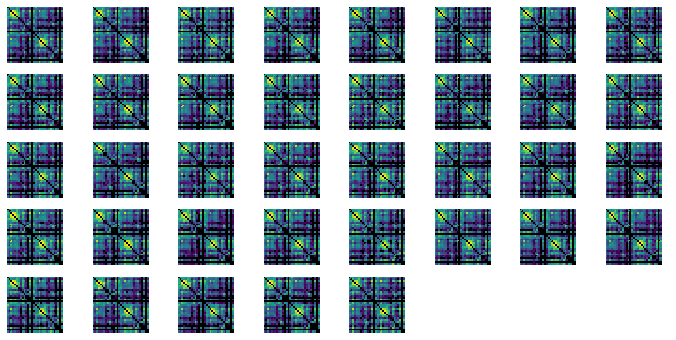

In [27]:
f, ax = plt.subplots(5, 8, figsize=(12, 6))

for s in tqdm(range(len(demographics_df["Subject"].tolist()))):
    df_test_subj = pd.DataFrame(test_conn_mat[:, :, s])
    df_test_subj = df_test_subj.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
    df_test_subj = df_test_subj.reindex(index=reindex_list, columns=reindex_list)

    # Plot
    sns.heatmap(
        np.log10(df_test_subj),
        ax=ax[int(s / 8)][s % 8],
        cmap="viridis",
        vmin=-1,
        vmax=4,
        square=True,
        cbar=None,
    )

    ax[int(s / 8)][s % 8].tick_params(axis="both", length=0)
    ax[int(s / 8)][s % 8].set_xticklabels("", va="top", ha="center")
    ax[int(s / 8)][s % 8].set_yticklabels("", rotation=0, va="top", ha="right")
    
for ax_i in range(5, 8):
    ax[4][ax_i].set_axis_off()

plt.show()
plt.close()

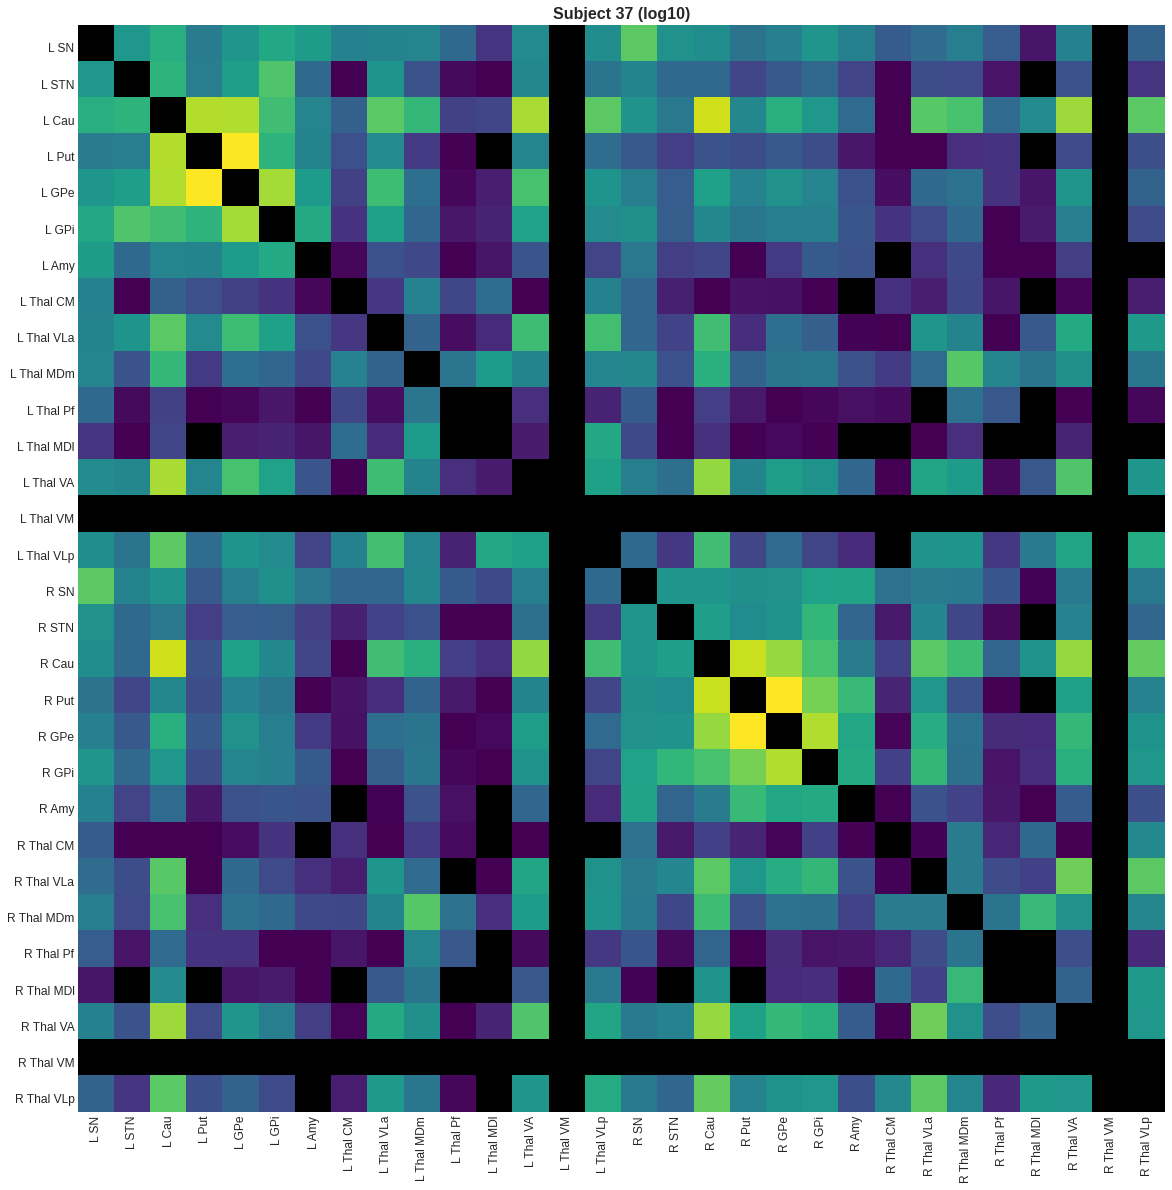

In [28]:
# Animation of individual subjects
def update(i):
    df_test_subj = pd.DataFrame(test_conn_mat[:, :, i])
    df_test_subj = df_test_subj.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

    # Reorganize dataframe by hemisphere
    df_test_subj = df_test_subj.reindex(index=reindex_list, columns=reindex_list)

    graph = sns.heatmap(
        np.log10(df_test_subj),
        ax=ax,
        cmap="viridis",
        vmin=-1,
        vmax=4,
        square=True,
        cbar=False,
    )

    ax.set_title("Subject {0} (log10)".format(i + 1))
    ax.set_xticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=90,
        va="top",
        ha="center",
    )
    ax.set_yticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=0,
        va="top",
        ha="right",
    )

    return (graph,)


fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.tick_params(axis="both", length=0)
ax.set_xticks(np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"])))
ax.set_xticklabels(
    parcellation_map.reindex(index=reindex_list)["Abbrev"],
    rotation=90,
    va="top",
    ha="center",
)
ax.set_yticks(np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"])))
ax.set_yticklabels(
    parcellation_map.reindex(index=reindex_list)["Abbrev"],
    rotation=0,
    va="top",
    ha="right",
)

ani = FuncAnimation(
    fig, update, frames=test_conn_mat.shape[2], interval=200, repeat=True
)

filename = f"{figure_dir}/test_subj_streamline_weight.gif"
# ani.save(filename, writer="imagemagick", fps=1)

HTML(ani.to_html5_video())

In [30]:
plt.close()

#### Group stats

In [37]:
test_conn_avgmat = np.nanmean(test_conn_mat, axis=2)
test_conn_stdmat = np.nanstd(test_conn_mat, axis=2)
test_conn_covmat = test_conn_stdmat / test_conn_avgmat

df_test_avg_subconn = pd.DataFrame(test_conn_avgmat)
df_test_avg_subconn = df_test_avg_subconn.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

df_test_std_subconn = pd.DataFrame(test_conn_stdmat)
df_test_std_subconn = df_test_std_subconn.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

df_test_cov_subconn = pd.DataFrame(test_conn_covmat)
df_test_cov_subconn = df_test_cov_subconn.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

# Add hemisphere and nuclei information
df_test_avg_subconn["nuclei"] = df_test_std_subconn["nuclei"] = df_test_cov_subconn[
    "nuclei"
] = parcellation_map["Abbrev"]

# Reorganize dataframe by hemisphere
df_test_avg_subconn = df_test_avg_subconn.reindex(
    index=reindex_list, columns=reindex_list
)
df_test_std_subconn = df_test_std_subconn.reindex(
    index=reindex_list, columns=reindex_list
)
df_test_cov_subconn = df_test_cov_subconn.reindex(
    index=reindex_list, columns=reindex_list
)

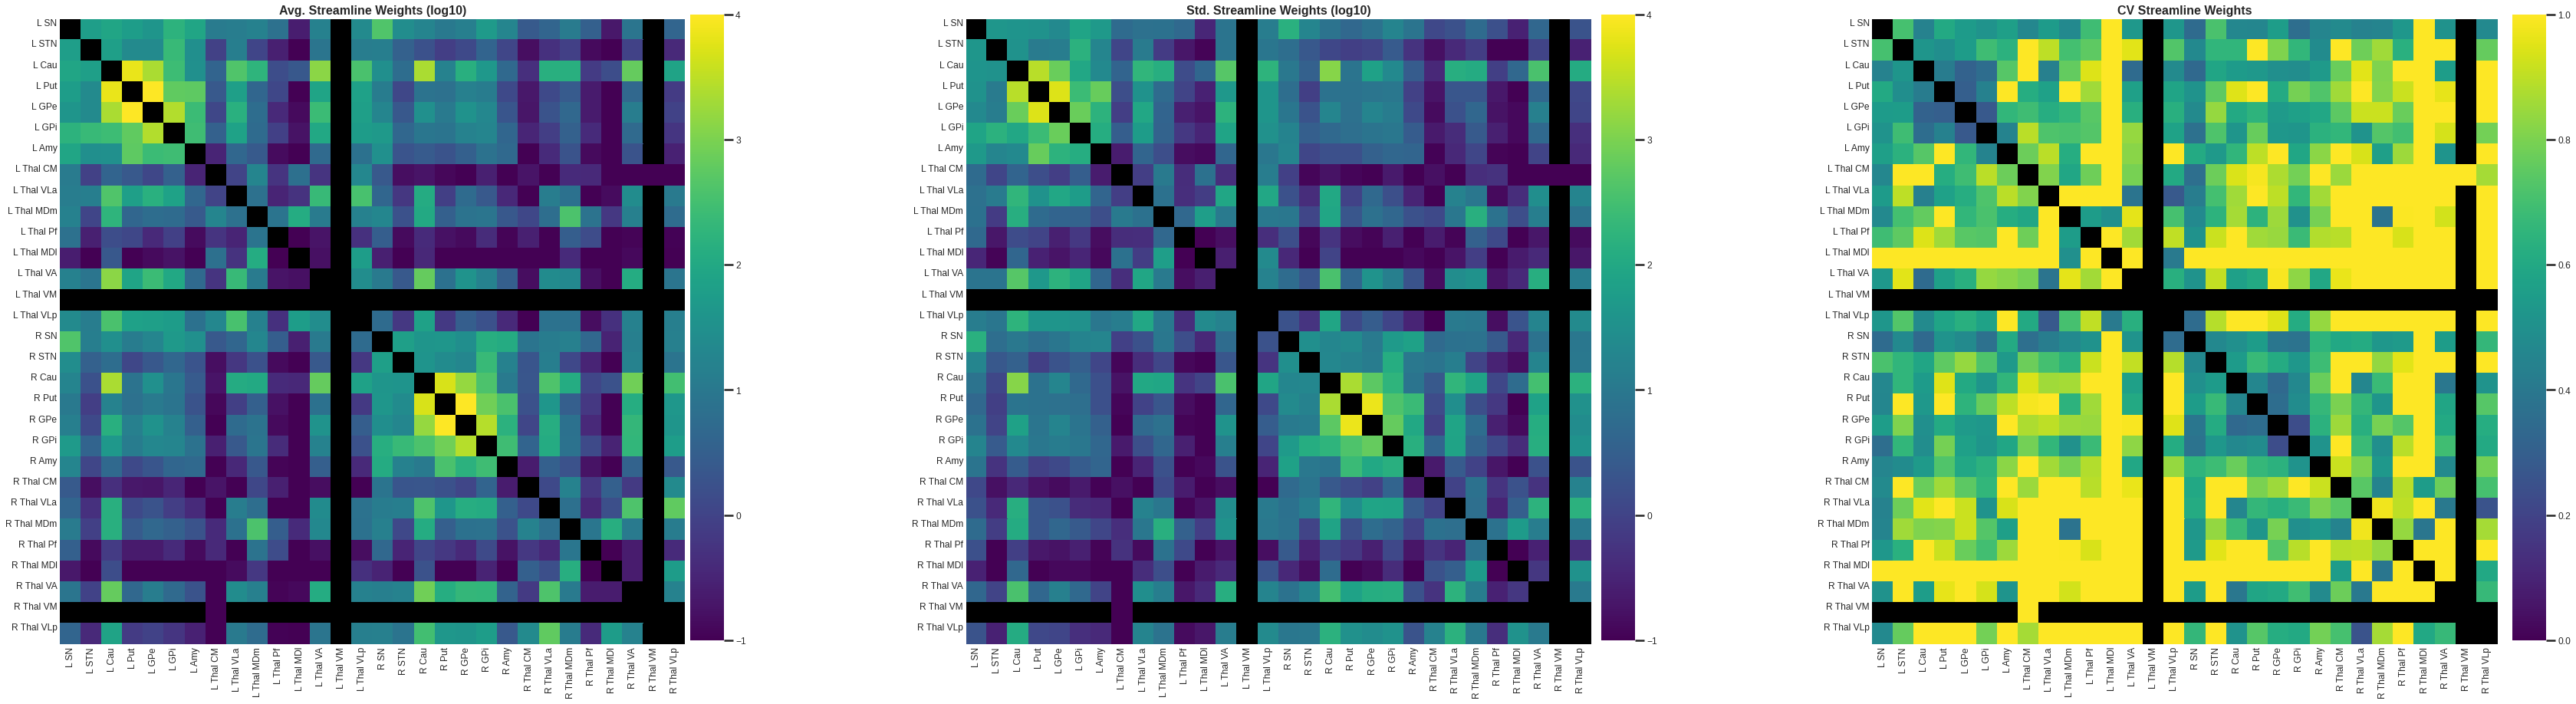

In [39]:
# Plot group stats
%matplotlib inline

f, ax = plt.subplots(1, 3, figsize=(60, 15))

# Average
cbar_ax1 = f.add_axes([0.335, 0.13, 0.01, 0.755])
sns.heatmap(
    np.log10(df_test_avg_subconn),
    ax=ax[0],
    cmap="viridis",
    vmin=-1,
    vmax=4,
    square=True,
    cbar_ax=cbar_ax1,
)
ax[0].set_title("Avg. Streamline Weights (log10)")

# Standard Deviation
cbar_ax2 = f.add_axes([0.610, 0.13, 0.01, 0.755])
sns.heatmap(
    np.log10(df_test_std_subconn),
    ax=ax[1],
    cmap="viridis",
    vmin=-1,
    vmax=4,
    square=True,
    cbar_ax=cbar_ax2,
)
ax[1].set_title("Std. Streamline Weights (log10)")

# COV
cbar_ax3 = f.add_axes([0.885, 0.13, 0.01, 0.755])
sns.heatmap(
    df_test_cov_subconn,
    ax=ax[2],
    cmap="viridis",
    vmin=0,
    vmax=1,
    square=True,
    cbar_ax=cbar_ax3,
)
ax[2].set_title("CV Streamline Weights")

# Labels
for d in range(3):
    ax[d].tick_params(axis="both", length=0)
    ax[d].set_xticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"], va="top", ha="center",
        rotation=90
    )
    ax[d].set_yticks(
        np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"]))
    )
    ax[d].set_yticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=0,
        va="top",
        ha="right",
    )

filename = "{0}/test_avg_streamline_weights.svg".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

In [40]:
# CV for all connections
test_avg = df_test_avg_subconn
test_avg = test_avg.replace(0, np.nan)
test_avg = test_avg.where(np.triu(np.ones(test_avg.shape), k=1).astype(np.bool))
test_avg = test_avg.values.flatten()
test_avg = test_avg[np.logical_not(np.isnan(test_avg))]

test_cv = df_test_cov_subconn
test_cv = test_cv.where(np.triu(np.ones(test_cv.shape), k=1).astype(np.bool))
test_cv = test_cv.values.flatten()
test_cv = test_cv[np.logical_not(np.isnan(test_cv))]

df_test_cv_vs_avg = pd.DataFrame(
    {"CV": test_cv, "Avg": test_avg, "Avg (log)": np.log10(test_avg)}
)
df_test_cv_vs_avg.sort_values(by=["CV"], inplace=True, ascending=False)

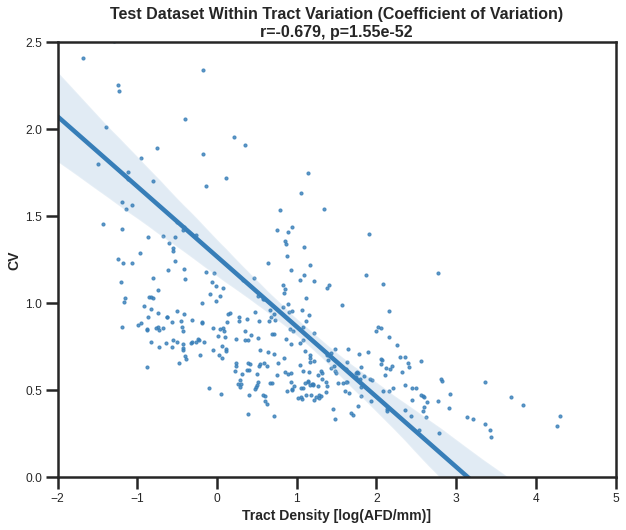

In [41]:
# Plot all CV
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.regplot(
    x="Avg (log)",
    y="CV",
    data=df_test_cv_vs_avg,
    ax=ax,
    ci=95,
    scatter_kws={"s": 10},
)

pstats = stats.spearmanr(df_test_cv_vs_avg["Avg (log)"], df_test_cv_vs_avg["CV"])


ax.set_title(
    f"""Test Dataset Within Tract Variation (Coefficient of Variation)
r={pstats[0]:.3f}, p={pstats[1]:.3g}"""
)
ax.set_xlabel("Tract Density [log(AFD/mm)]")
ax.set_ylim([0, 2.5])
ax.set_xlim([-2, 5])

filename = "{0}/test_all_cv.svg".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

In [42]:
handle_session(save=True)

Saving notebook session


### HCP1200 3T Retest Analysis<a class="anchor" id="retest_analysis"></a>

In [43]:
# Read in subject and label data
subjlist = pd.read_csv(f"{zona_dir}/participants.tsv", header=None)

for subjIdx, subj in enumerate(tqdm(demographics_df["Subject"].tolist())):
    subj = f"sub-{subj}"
    csv_file = f"{retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subj}/tractography/{subj}_space-dwi_desc-subcortical_nodeweights.csv"

    if subjIdx is 0:
        retest_conn_mat = np.genfromtxt(csv_file, delimiter=" ")
        retest_conn_mat = retest_conn_mat[:, :, np.newaxis]
    else:
        temp_mat = np.genfromtxt(csv_file, delimiter=" ")
        temp_mat = temp_mat[:, :, np.newaxis]
        retest_conn_mat = np.append(retest_conn_mat, temp_mat, axis=2)

100%|██████████| 37/37 [00:03<00:00, 10.68it/s]


#### Individual subjects

100%|██████████| 37/37 [00:08<00:00,  4.42it/s]


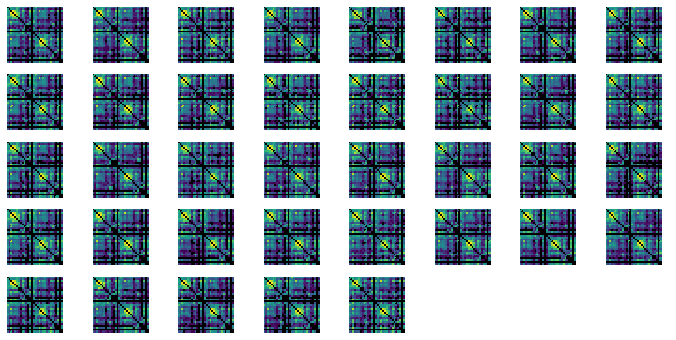

In [45]:
f, ax = plt.subplots(5, 8, figsize=(12, 6))

for s in tqdm(range(len(demographics_df["Subject"].tolist()))):
    df_retest_subj = pd.DataFrame(retest_conn_mat[:, :, s])
    df_retest_subj = df_retest_subj.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
    # Rearrange
    df_retest_subj = df_retest_subj.reindex(index=reindex_list, columns=reindex_list)

    # Plot
    sns.heatmap(
        np.log10(df_retest_subj),
        ax=ax[int(s / 8)][s % 8],
        cmap="viridis",
        vmin=-1,
        vmax=4,
        square=True,
        cbar=None,
    )

    ax[int(s / 8)][s % 8].tick_params(axis="both", length=0)
    ax[int(s / 8)][s % 8].set_xticklabels("", va="top", ha="center")
    ax[int(s / 8)][s % 8].set_yticklabels("", rotation=0, va="top", ha="right")

for ax_i in range(5, 8):
    ax[4][ax_i].set_axis_off()

plt.show()
plt.close()

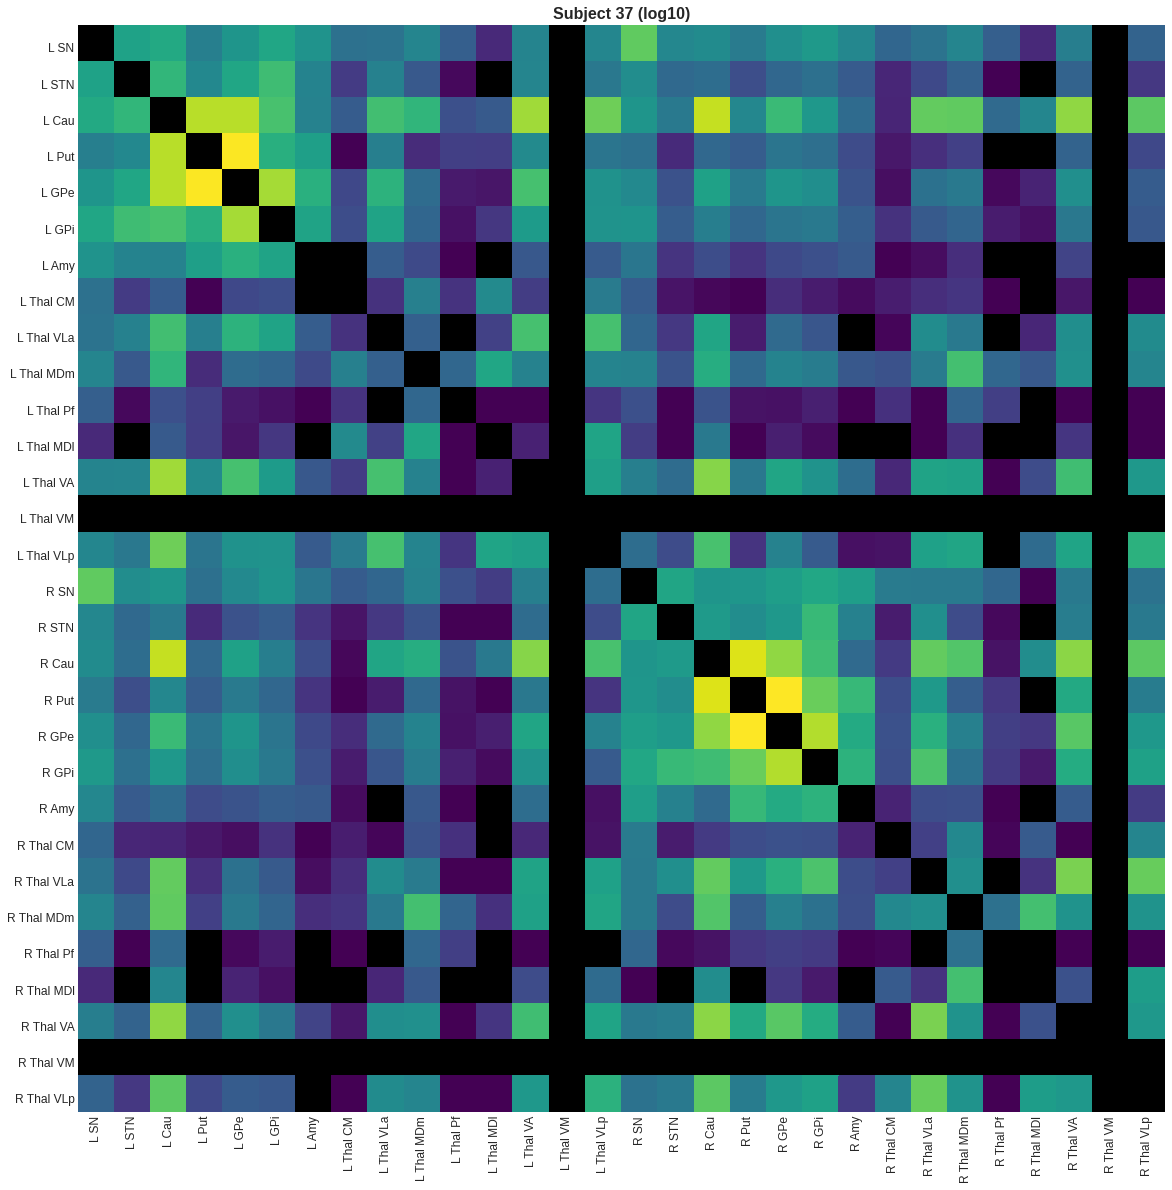

In [46]:
# Animation of individual subjects
def update(i):
    df_retest_subj = pd.DataFrame(retest_conn_mat[:, :, i])
    df_retest_subj = df_retest_subj.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
    # Reorganize dataframe by hemisphere
    df_retest_subj = df_retest_subj.reindex(index=reindex_list, columns=reindex_list)

    graph = sns.heatmap(
        np.log10(df_retest_subj),
        ax=ax,
        cmap="viridis",
        vmin=-1,
        vmax=4,
        square=True,
        cbar=False,
    )

    ax.set_title("Subject {0} (log10)".format(i + 1))
    ax.set_xticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=90,
        va="top",
        ha="center",
    )
    ax.set_yticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=0,
        va="top",
        ha="right",
    )

    return (graph,)


fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.tick_params(axis="both", length=0)
ax.set_xticks(np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"])))
ax.set_xticklabels(
    parcellation_map.reindex(index=reindex_list)["Abbrev"],
    rotation=90,
    va="top",
    ha="center",
)
ax.set_yticks(np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"])))
ax.set_yticklabels(
    parcellation_map.reindex(index=reindex_list)["Abbrev"],
    rotation=0,
    va="top",
    ha="right",
)

ani = FuncAnimation(
    fig, update, frames=retest_conn_mat.shape[2], interval=200, repeat=True
)

filename = f"{figure_dir}/retest_subj_streamline_weight.gif"
# ani.save(filename, writer="imagemagick", fps=1)

HTML(ani.to_html5_video())

In [35]:
plt.close()

#### Group stats

In [48]:
retest_conn_avgmat = np.nanmean(retest_conn_mat, axis=2)
retest_conn_stdmat = np.nanstd(retest_conn_mat, axis=2)
retest_conn_covmat = retest_conn_stdmat / retest_conn_avgmat

df_retest_avg_subconn = pd.DataFrame(retest_conn_avgmat)
df_retest_avg_subconn = df_retest_avg_subconn.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

df_retest_std_subconn = pd.DataFrame(retest_conn_stdmat)
df_retest_std_subconn = df_retest_std_subconn.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

df_retest_cov_subconn = pd.DataFrame(retest_conn_covmat)
df_retest_cov_subconn = df_retest_cov_subconn.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

# Add hemisphere and nuclei information
df_retest_avg_subconn["nuclei"] = df_retest_std_subconn[
    "nuclei"
] = df_retest_cov_subconn["nuclei"] = parcellation_map["Abbrev"]

# Reorganize dataframe by hemisphere
df_retest_avg_subconn = df_retest_avg_subconn.reindex(
    index=reindex_list, columns=reindex_list
)
df_retest_std_subconn = df_retest_std_subconn.reindex(
    index=reindex_list, columns=reindex_list
)
df_retest_cov_subconn = df_retest_cov_subconn.reindex(
    index=reindex_list, columns=reindex_list
)

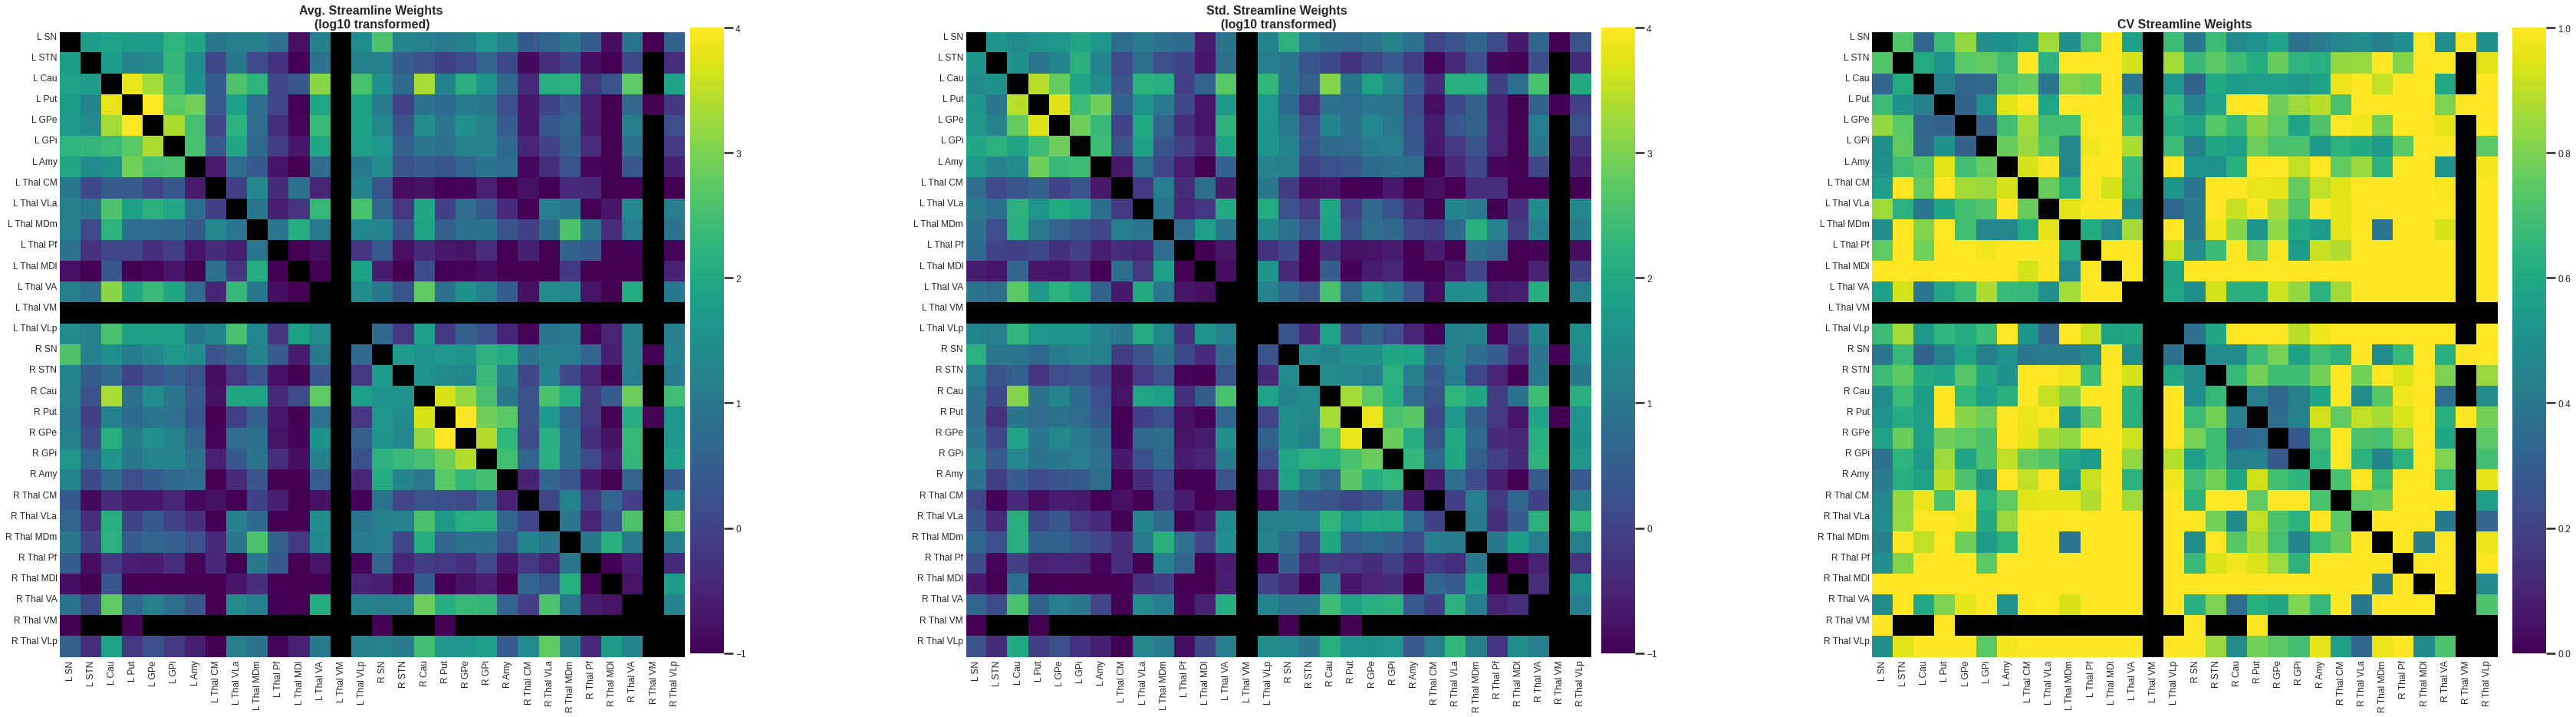

In [49]:
# Plot group stats
%matplotlib inline

f, ax = plt.subplots(1, 3, figsize=(60, 15))

# Average
cbar_ax1 = f.add_axes([0.335, 0.13, 0.01, 0.755])
sns.heatmap(
    np.log10(df_retest_avg_subconn),
    ax=ax[0],
    cmap="viridis",
    vmin=-1,
    vmax=4,
    square=True,
    cbar_ax=cbar_ax1,
)
ax[0].set_title("Avg. Streamline Weights \n(log10 transformed)")

# Standard Deviation
cbar_ax2 = f.add_axes([0.610, 0.13, 0.01, 0.755])
sns.heatmap(
    np.log10(df_retest_std_subconn),
    ax=ax[1],
    cmap="viridis",
    vmin=-1,
    vmax=4,
    square=True,
    cbar_ax=cbar_ax2,
)
ax[1].set_title("Std. Streamline Weights \n(log10 transformed)")

# COV
cbar_ax3 = f.add_axes([0.885, 0.13, 0.01, 0.755])
sns.heatmap(
    df_retest_cov_subconn,
    ax=ax[2],
    cmap="viridis",
    vmin=0,
    vmax=1,
    square=True,
    cbar_ax=cbar_ax3,
)
ax[2].set_title("CV Streamline Weights")

# Labels
for d in range(3):
    ax[d].tick_params(axis="both", length=0)
    ax[d].set_xticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"], va="top", ha="center",
        rotation=90
    )
    ax[d].set_yticks(np.arange(len(parcellation_map.reindex(index=reindex_list))))
    ax[d].set_yticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=0,
        va="top",
        ha="right",
    )

filename = f"{figure_dir}/retestavg_streamline_weights.svg"
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

In [50]:
# CV for all connections
retest_avg = df_retest_avg_subconn
retest_avg = retest_avg.replace(0, np.nan)
retest_avg = retest_avg.where(np.triu(np.ones(retest_avg.shape), k=1).astype(np.bool))
retest_avg = retest_avg.values.flatten()
retest_avg = retest_avg[np.logical_not(np.isnan(retest_avg))]

retest_cv = df_retest_cov_subconn
retest_cv = retest_cv.where(np.triu(np.ones(retest_cv.shape), k=1).astype(np.bool))
retest_cv = retest_cv.values.flatten()
retest_cv = retest_cv[np.logical_not(np.isnan(retest_cv))]

df_retest_cv_vs_avg = pd.DataFrame(
    {"CV": retest_cv, "Avg": retest_avg, "Avg (log)": np.log10(retest_avg)}
)
df_retest_cv_vs_avg.sort_values(by=["CV"], inplace=True, ascending=False)

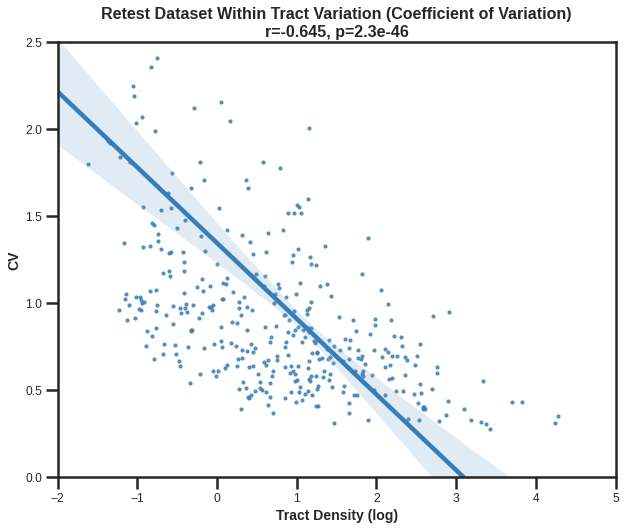

In [51]:
# Plot all CV
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.regplot(
    x="Avg (log)",
    y="CV",
    data=df_retest_cv_vs_avg,
    ax=ax,
    ci=95,
    scatter_kws={"s": 10},
)

pstats = stats.spearmanr(df_retest_cv_vs_avg["Avg (log)"], df_retest_cv_vs_avg["CV"])


ax.set_title(
    f"""Retest Dataset Within Tract Variation (Coefficient of Variation)
r={pstats[0]:.3f}, p={pstats[1]:.3g}"""
)
ax.set_xlabel("Tract Density (log)")
ax.set_ylim([0, 2.5])
ax.set_xlim([-2, 5])

filename = "{0}/retest_all_cv.svg".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

In [52]:
handle_session(save=True)

Saving notebook session


### Test vs Retest <a class="anchor" id="test_v_retest"></a>

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:09<00:00,  4.06it/s]


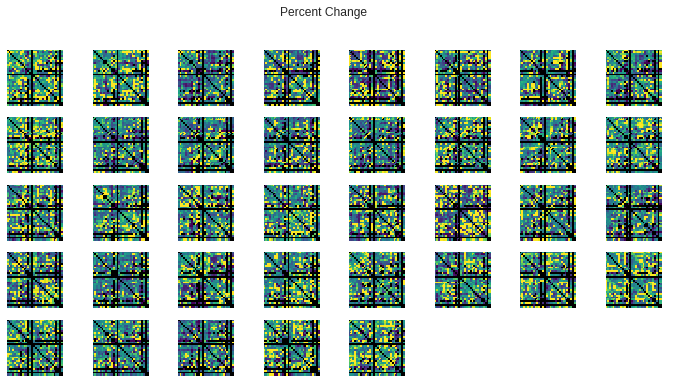

In [14]:
# Individual subjects
diff_conn_mat = np.copy(test_conn_mat)

# Update to percent change
for subjIdx, subj in enumerate(demographics_df["Subject"].tolist()):
    diff_conn_mat[:, :, subjIdx] = (
        np.divide(
            np.subtract(retest_conn_mat[:, :, subjIdx], test_conn_mat[:, :, subjIdx]),
            test_conn_mat[:, :, subjIdx],
        )
        * 100
    )
    diff_conn_mat[np.where(np.abs(diff_conn_mat) == np.inf)] = np.nan

f, ax = plt.subplots(5, 8, figsize=(12, 6))

plt.suptitle("Percent Change")

for s in tqdm(range(len(demographics_df["Subject"].tolist()))):
    df_diff_subj = pd.DataFrame(diff_conn_mat[:, :, s])
    df_diff_subj = df_diff_subj.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
    df_diff_subj = df_diff_subj.reindex(index=reindex_list, columns=reindex_list)

    # Plot
    sns.heatmap(
        df_diff_subj,
        ax=ax[int(s / 8)][s % 8],
        cmap="viridis",
        vmin=-100,
        vmax=100,
        square=True,
        cbar=None,
    )

    ax[int(s / 8)][s % 8].tick_params(axis="both", length=0)
    ax[int(s / 8)][s % 8].set_xticklabels("", va="top", ha="center")
    ax[int(s / 8)][s % 8].set_yticklabels("", rotation=0, va="top", ha="right")

for ax_i in range(5, 8):
    ax[4][ax_i].set_axis_off()

plt.show()
plt.close()

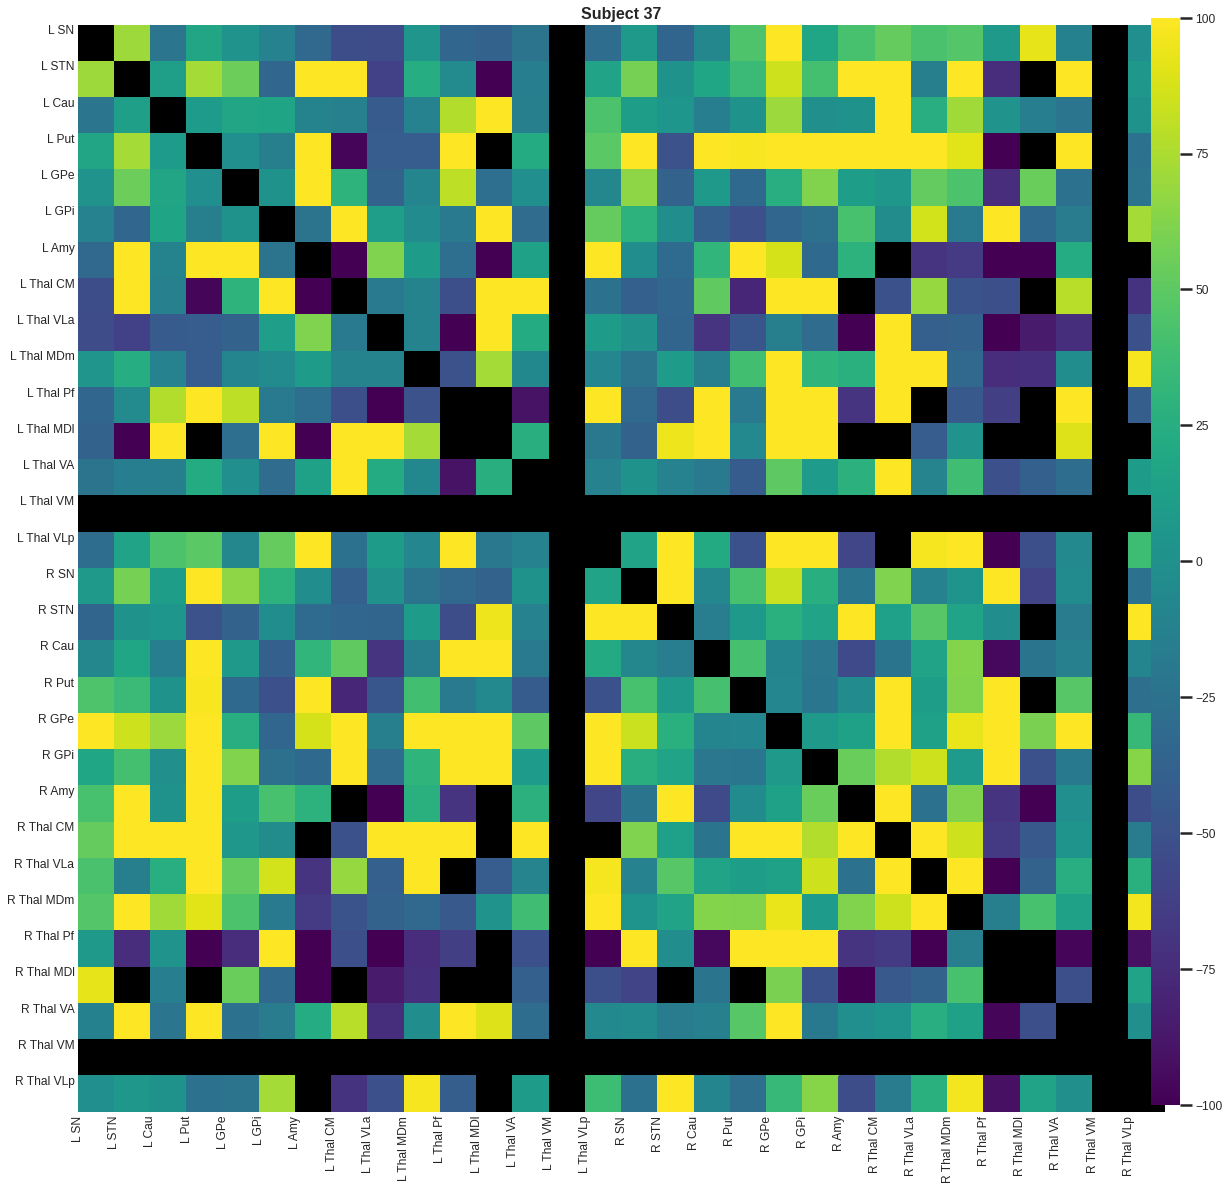

In [54]:
# Plot animated individual subjects
def update(i):
    df_diff_subj = pd.DataFrame(diff_conn_mat[:, :, i])
    df_diff_subj = df_diff_subj.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
    df_diff_subj = df_diff_subj.reindex(index=reindex_list, columns=reindex_list)

    cbar_ax = fig.add_axes([0.880, 0.13, 0.02, 0.755])
    graph = sns.heatmap(
        df_diff_subj,
        ax=ax,
        cmap="viridis",
        vmin=-100,
        vmax=100,
        square=True,
        cbar_ax=cbar_ax,
    )

    ax.set_title("Subject {0}".format(i + 1))
    ax.tick_params(axis="both", length=0)
    ax.set_xticks(
        np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"]))
    )
    ax.set_xticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=90,
        va="top",
        ha="center",
    )
    ax.set_yticks(
        np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"]))
    )
    ax.set_yticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=0,
        va="top",
        ha="right",
    )


fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ani = FuncAnimation(
    fig, update, frames=diff_conn_mat.shape[2], interval=200, repeat=True
)

HTML(ani.to_html5_video())

In [55]:
plt.close()

#### Averaged stats

In [15]:
# Create data frame
df_test = pd.DataFrame(np.nanmean(test_conn_mat, axis=2))
df_test = df_test.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
df_test = df_test.replace(0, np.nan)
df_retest = pd.DataFrame(np.nanmean(retest_conn_mat, axis=2))
df_retest = df_retest.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)
df_retest = df_retest.replace(0, np.nan)

# Add labels
df_test["hemi"] = parcellation_map["Hemi"]
df_test["nuclei"] = parcellation_map["Nuclei"]
df_retest["hemi"] = parcellation_map["Hemi"]
df_retest["nuclei"] = parcellation_map["Nuclei"]

# Reorganize by hemi
df_test.sort_values(by=["nuclei"], inplace=True)
temp_list = df_test.index.tolist()
temp_list.append("hemi")
temp_list.append("nuclei")
df_test.sort_values(by=["nuclei"], inplace=True)
df_test = df_test.reindex(columns=temp_list)
df_retest.sort_values(by=["nuclei"], inplace=True)
df_retest = df_retest.reindex(columns=temp_list)


# Get hemispheric connections
test_vals, retest_vals = [], []

test_left = df_test.iloc[0:15, 0:15].to_numpy()[np.triu_indices(15, k=1)]
retest_left = df_retest.iloc[0:15, 0:15].to_numpy()[np.triu_indices(15, k=1)]
hemi = ["Left" for i in range(len(test_left))]
test_vals = np.append(test_vals, test_left)
retest_vals = np.append(retest_vals, retest_left)

test_right = df_test.iloc[15:30, 15:30].to_numpy()[np.triu_indices(15, k=1)]
retest_right = df_retest.iloc[15:30, 15:30].to_numpy()[np.triu_indices(15, k=1)]
hemi = np.append(hemi, ["Right" for i in range(len(test_right))])
test_vals = np.append(test_vals, test_right)
retest_vals = np.append(retest_vals, retest_right)

test_inter = df_test.iloc[0:15, 15:30].to_numpy().flatten()
retest_inter = df_retest.iloc[0:15, 15:30].to_numpy().flatten()
hemi = np.append(hemi, ["Inter" for i in range(len(test_inter))])
test_vals = np.append(test_vals, test_inter)
retest_vals = np.append(retest_vals, retest_inter)


# Create dataframe to store data for plotting
df_test_retest = pd.DataFrame(
    {
        "Test": np.log10(test_vals),
        "Retest": np.log10(retest_vals),
        "Avg": np.log10(np.nanmean(np.array([test_vals, retest_vals]), axis=0)),
        "Hemi": hemi,
    }
)

del (
    df_test,
    df_retest,
    temp_list,
    hemi,
    test_left,
    retest_left,
    test_vals,
    retest_vals,
    test_right,
    retest_right,
)

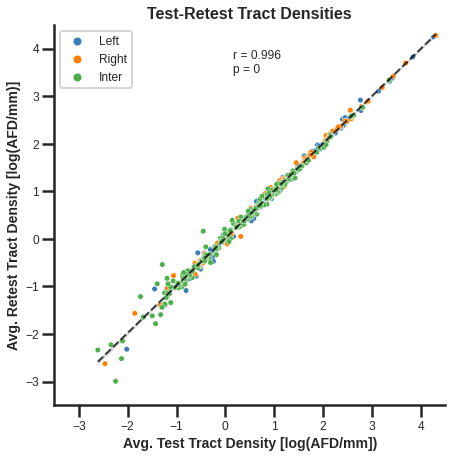

In [16]:
# Plot individual stats
%matplotlib inline

f, ax = plt.subplots(1, 1, figsize=(7, 7))

sns.scatterplot(
    data=df_test_retest, x="Test", y="Retest", hue="Hemi", ax=ax, s=30, alpha=1
)
sns.regplot(
    data=df_test_retest,
    x="Test",
    y="Retest",
    ax=ax,
    scatter=False,
    color="black",
    ci=95,
    line_kws={"lw": 2, "linestyle": "--", "alpha": 0.75},
    scatter_kws={"alpha": 0.5, "s": 12},
)

# Test for normality
normality = True
stats_sym = "r"
if stats.shapiro(df_test_retest["Test"].dropna())[1] < 0.05 or stats.shapiro(df_test_retest["Retest"].dropna())[1] < 0.05:
    normality = False
    stats_sym = "$\\rho$"

pstats = (
    stats.pearsonr(df_test_retest.dropna()["Test"], df_test_retest.dropna()["Retest"])
    if normality
    else stats.spearmanr(df_test_retest["Test"],df_test_retest["Retest"], nan_policy="omit")
)

# Legend parms
ax.legend(fontsize=12, markerscale=0.5)

# Plot params
ax.set_xlim([-3.5, 4.5])
ax.set_ylim([-3.5, 4.5])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylabel("Avg. Retest Tract Density [log(AFD/mm)]")
ax.set_xlabel("Avg. Test Tract Density [log(AFD/mm])")
ax.set_title(f"Test-Retest Tract Densities")
ax.text(
    0.15,
    3.5,
    f"""{stats_sym} = {pstats[0]:.3f} 
p = {pstats[1]:.3g}""",
    fontsize=12,
)

# filename = f"{figure_dir}/comparison_scatter.png"
# plt.savefig(filename, dpi=600, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

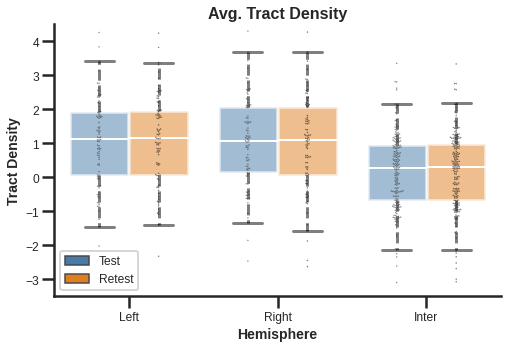

In [17]:
# Plot hemispheric differences
%matplotlib inline

df = df_test_retest.melt(
    id_vars=["Hemi"],
    value_vars=["Test", "Retest"],
    var_name="Session",
    value_name="Density",
)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.boxplot(
    data=df,
    x="Hemi",
    y="Density",
    hue="Session",
    dodge=True,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    showfliers=False,
    whis=0.95,
)
sns.swarmplot(
    data=df,
    x="Hemi",
    y="Density",
    hue="Session",
    color="black",
    alpha=0.5,
    dodge=True,
    size=1.5,
)

ax.set_ylim([-3.5, 4.5])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.title("Avg. Tract Density")
plt.ylabel("Tract Density")
plt.xlabel("Hemisphere")

# filename = f"{figure_dir}/percent_diff_by_hemi.png"
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

# del df

In [18]:
diff_conn_avgmat = np.nanmean(diff_conn_mat, axis=2)
diff_conn_stdmat = np.nanstd(diff_conn_mat, axis=2)

df_avg_subconn = pd.DataFrame(diff_conn_avgmat)
df_avg_subconn = df_avg_subconn.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

df_std_subconn = pd.DataFrame(diff_conn_stdmat)
df_std_subconn = df_std_subconn.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

# Reorganize dataframe by hemisphere
df_avg_subconn = df_avg_subconn.reindex(index=reindex_list, columns=reindex_list)
df_std_subconn = df_std_subconn.reindex(index=reindex_list, columns=reindex_list)

In [19]:
# Statistical testing for differences between test vs retest
pval_mat = np.copy(diff_conn_mat[:, :, 0])

uncor_pval = np.array([])
for (i, j) in itertools.combinations(range(diff_conn_mat.shape[0]), 2):
    test_values = test_conn_mat[i, j, :]
    retest_values = retest_conn_mat[i, j, :]

    tstat, pval = stats.ttest_rel(test_values, retest_values, nan_policy="omit")
    uncor_pval = np.append(uncor_pval, pval)

nan_idx = np.argwhere(np.isnan(uncor_pval))
uncor_pval = np.delete(uncor_pval, nan_idx)
_, cor_pval = fdrcorrection(uncor_pval)
for idx in nan_idx:
    cor_pval = np.insert(cor_pval, idx, np.nan)

k = 0
for (i, j) in itertools.combinations(range(test_conn_mat.shape[0]), 2):
    pval_mat[i][i] = np.nan

    pval_mat[i][j] = cor_pval[k]
    pval_mat[j][i] = cor_pval[k]
    k += 1

df_pval_mat = pd.DataFrame(pval_mat)
df_pval_mat = df_pval_mat.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

# Reorganize dataframe by hemisphere
df_pval_mat = df_pval_mat.reindex(index=reindex_list, columns=reindex_list)

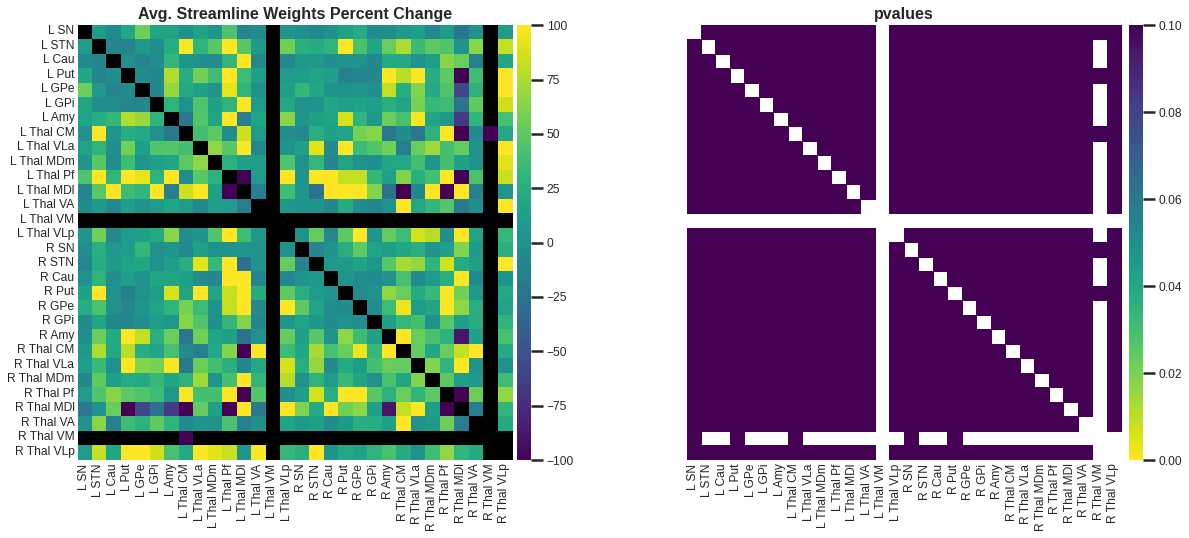

In [20]:
# Plot significant differences
%matplotlib inline

f, ax = plt.subplots(1, 2, figsize=(20, 8))

# Average
cbar_ax1 = f.add_axes([0.455, 0.125, 0.01, 0.755])
sns.heatmap(
    df_avg_subconn,
    ax=ax[0],
    cmap="viridis",
    vmin=-100,
    vmax=100,
    square=True,
    cbar_ax=cbar_ax1,
)
ax[0].set_title("Avg. Streamline Weights Percent Change")

# P-Values
cbar_ax2 = f.add_axes([0.880, 0.125, 0.01, 0.755])
sns.heatmap(
    df_pval_mat,
    ax=ax[1],
    cmap="viridis_r",
    vmin=0.0,
    vmax=0.1,
    square=True,
    cbar_ax=cbar_ax2,
)
ax[1].set_title("pvalues")

for d in range(2):
    ax[d].tick_params(axis="both", length=0)
    ax[d].set_xticks(
        np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"]))
    )
    ax[d].set_xticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"], va="top", ha="left",
        rotation=90
    )
    if d == 0:
        ax[d].set_yticks(
            np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"]))
        )
        ax[d].set_yticklabels(
            parcellation_map.reindex(index=reindex_list)["Abbrev"],
            rotation=0,
            va="top",
            ha="right",
        )
    else:
        ax[d].set_yticklabels("")

plt.show()
plt.close()

#### Percent change

In [21]:
# Left
df_avg_subconn["Nuclei"] = parcellation_map.reindex(index=reindex_list)["Nuclei"]
df_avg_subconn = df_avg_subconn.sort_values(by=["Nuclei"])
df_avg_subconn = df_avg_subconn.reindex(columns=df_avg_subconn.index.tolist())

diff_value = df_avg_subconn.iloc[0:15, 0:15].to_numpy()[np.triu_indices(15, k=1)]
hemi = ["Left" for i in range(len(diff_value))]

# Right
diff_R = df_avg_subconn.iloc[15:30, 15:30].to_numpy()[np.triu_indices(15, k=1)]
diff_value = np.append(diff_value, diff_R)
hemi = np.append(hemi, ["Right" for i in range(len(diff_R))])

# Inter
diff_int = df_avg_subconn.iloc[0:15, 15:30]
diff_int = diff_int.values.flatten()
diff_value = np.append(diff_value, diff_int)
hemi = np.append(hemi, ["Inter" for i in range(len(diff_int))])

# Dataframe
df_diff = pd.DataFrame({"Value": diff_value, "Hemi": hemi})

del diff_int, diff_value, hemi

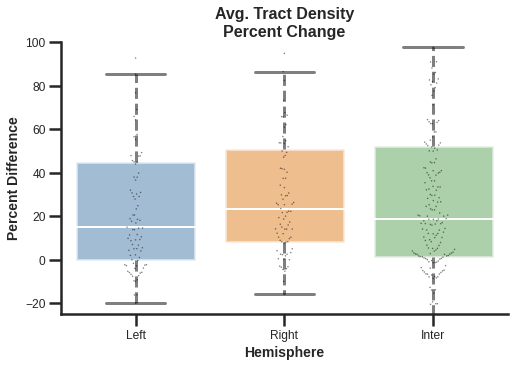

In [22]:
# Plot hemispheric differences
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.boxplot(
    data=df_diff,
    x="Hemi",
    y="Value",
    hue="Hemi",
    dodge=False,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    showfliers=False,
    whis=0.95,
)
sns.swarmplot(
    data=df_diff, x="Hemi", y="Value", color="black", alpha=0.5, dodge=False, size=1.5
)

ax.set_ylim([-25, 100])
ax.get_legend().remove()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.title("Avg. Tract Density\nPercent Change")
plt.ylabel("Percent Difference")
plt.xlabel("Hemisphere")

# filename = f"{figure_dir}/percent_diff_by_hemi.png"
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

In [23]:
df_diff.groupby("Hemi").describe()

Value                                                                \
       count       mean         std    min       25%        50%        75%   
Hemi                                                                         
Inter  197.0  42.031935  110.344474 -100.0  1.557835  18.968034  52.575453   
Left    91.0  33.595246   67.940988 -100.0 -0.057516  15.076175  45.010569   
Right   91.0  33.158356   44.129960 -100.0  8.403265  23.619544  51.089854   

                   
              max  
Hemi               
Inter  996.552172  
Left   474.166771  
Right  177.196362

#### Intraclass Correlation

Here, we are looking at how reproducible the streamline weights are across sessions for each subject

In [4]:
# Set up ICC dataframe
groups = np.ones(test_conn_mat.shape[2])
groups = np.concatenate((groups, np.ones(test_conn_mat.shape[2]) + 1))
ids = np.arange(test_conn_mat.shape[2])
ids = np.concatenate((ids, ids))

icc = np.zeros((test_conn_mat.shape[0], test_conn_mat.shape[1]))

for (i, j) in tqdm(itertools.combinations(range(test_conn_mat.shape[0]), 2)):
    icc[i][i] = np.nan

    values_test = test_conn_mat[i, j, :]
    values_retest = retest_conn_mat[i, j, :]

    values = np.concatenate((values_test, values_retest))

    icc_df = pd.DataFrame({"sample": groups, "id": ids, "value": np.log10(values)})

    icc_res = pg.intraclass_corr(
        data=icc_df, targets="id", raters="sample", ratings="value"
    ).round(3)
    icc_type = "ICC2"
    icc[i][j] = icc_res[icc_res["Type"] == icc_type]["ICC"].values[0]
    icc[j][i] = icc[i][j]

# Create dataframe
df_icc_mat = pd.DataFrame(icc)
df_icc_mat = df_icc_mat.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

# Reorganize dataframe by hemisphere
df_icc_mat = df_icc_mat.reindex(index=reindex_list, columns=reindex_list)

del groups, ids, icc, values_test, values_retest, values, icc_res, icc_type

2556it [03:22, 12.63it/s]


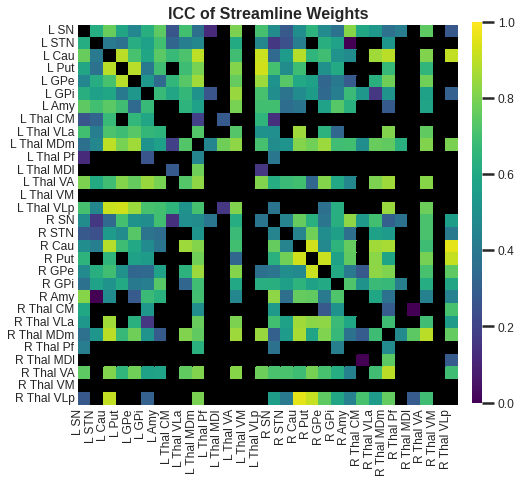

In [5]:
# Plot ICC
%matplotlib inline

df_icc_mat = df_icc_mat.reindex(
    index=reindex_list, columns=reindex_list
)

f, ax = plt.subplots(1, 1, figsize=(14, 7))

# Average
cbar_ax1 = f.add_axes([0.715, 0.13, 0.01, 0.755])
sns.heatmap(
    df_icc_mat,
    ax=ax,
    cmap="viridis",
    vmin=0,
    vmax=1,
    square=True,
    cbar_ax=cbar_ax1,
)
ax.set_title("ICC of Streamline Weights")

ax.tick_params(axis="both", length=0)
ax.set_xticks(np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"])))
ax.set_xticklabels(
    parcellation_map.reindex(index=reindex_list)["Abbrev"], va="top", ha="center"
)
ax.set_yticks(np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"])))
ax.set_yticklabels(
    parcellation_map.reindex(index=reindex_list)["Abbrev"],
    rotation=0,
    va="top",
    ha="right",
)

filename = "{0}/comparison_streamline_icc.svg".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

In [7]:
# Left
df_icc_mat["Nuclei"] = parcellation_map.reindex(index=reindex_list)["Nuclei"]
df_icc_mat = df_icc_mat.sort_values(by=["Nuclei"])
df_icc_mat = df_icc_mat.reindex(columns=df_icc_mat.index.tolist())

diff_value = df_icc_mat.iloc[0:15, 0:15].to_numpy()[np.triu_indices(15, k=1)]
hemi = ["Left" for i in range(len(diff_value))]

# Right
diff_R = df_icc_mat.iloc[15:30, 15:30].to_numpy()[np.triu_indices(15, k=1)]
diff_value = np.append(diff_value, diff_R)
hemi = np.append(hemi, ["Right" for i in range(len(diff_R))])

# Inter
diff_int = df_icc_mat.iloc[0:15, 15:30]
diff_int = diff_int.values.flatten()
diff_value = np.append(diff_value, diff_int)

hemi = np.append(hemi, ["Inter" for i in range(len(diff_int))])

# Dataframe
df_icc_diff = pd.DataFrame({"Value": diff_value, "Hemi": hemi})

del diff_value, hemi, diff_R, diff_int

In [8]:
df_icc_diff.groupby("Hemi").describe()

Value                                                            
       count      mean       std    min      25%     50%      75%    max
Hemi                                                                    
Inter  104.0  0.570519  0.197818 -0.055  0.42425  0.5780  0.73575  0.907
Left    68.0  0.621882  0.196795  0.120  0.49550  0.6740  0.75500  0.928
Right   66.0  0.612273  0.198768 -0.114  0.47175  0.6325  0.75450  0.958

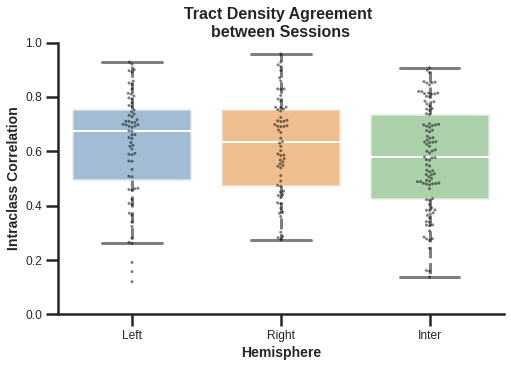

In [9]:
# Plot hemispheric differences
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.boxplot(
    data=df_icc_diff,
    x="Hemi",
    y="Value",
    hue="Hemi",
    dodge=False,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    showfliers=False,
    whis=0.95,
)
sns.swarmplot(
    data=df_icc_diff,
    x="Hemi",
    y="Value",
    color="black",
    alpha=0.5,
    dodge=False,
    size=3,
)

ax.set_ylim([0, 1])
ax.get_legend().remove()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.title("Tract Density Agreement \nbetween Sessions")
plt.ylabel("Intraclass Correlation")
plt.xlabel("Hemisphere")

filename = "{0}/comparison_hemi_icc.png".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

In [28]:
handle_session(save=True)

Saving notebook session


#### Tract overlap (wDSC)

In [29]:
dsc_mat = test_conn_mat.copy()

for s, subj in enumerate(tqdm(demographics_df["Subject"].tolist(), position=0)):
    subj = f"sub-{subj}"
    try:
        os.system(
            f"tar -xf {test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subj}/tdi/{subj}_tdi.tar -C {test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subj}/tdi --wildcards *.nii.gz"
        )
        os.system(
            f"tar -xf {retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subj}/tdi/{subj}_tdi.tar -C {retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subj}/tdi --wildcards *.nii.gz"
        )
    except:
        continue

    dsc = Parallel(n_jobs=n_proc, backend="multiprocessing")(
        delayed(compute_dsc, has_shareable_memory)(subj, node1, node2, weighted=True)
        for (node1, node2) in list(
            itertools.combinations(range(1, dsc_mat.shape[0] + 1), 2)
        )
    )

    dsc_mat[:, :, s] = make_mat(dsc, dsc_mat.shape[0])

    os.system(
        f"rm -f {test_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subj}/tdi/*.nii.gz"
    )
    os.system(
        f"rm -f {retest_dir}/derivatives/mrtpipelines_0.1.6/mrtpipelines/{subj}/tdi/*.nii.gz"
    )

    del dsc
    clear_output(wait=False)

handle_session(save=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [9:25:58<00:00, 917.81s/it]


Saving notebook session


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:09<00:00,  4.01it/s]


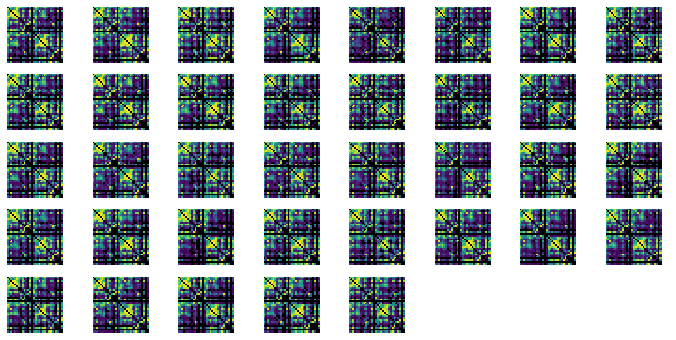

In [5]:
# Plot individual subjects
f, ax = plt.subplots(5, 8, figsize=(12, 6))

for s, _ in enumerate(tqdm(demographics_df["Subject"].tolist())):
    np.fill_diagonal(dsc_mat[:, :, s], np.nan)
    df_dsc_subj = pd.DataFrame(dsc_mat[:, :, s])
    df_dsc_subj = df_dsc_subj.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

    # Reorganize dataframe by hemisphere
    df_dsc_subj = df_dsc_subj.reindex(index=reindex_list, columns=reindex_list)

    sns.heatmap(
        df_dsc_subj,
        ax=ax[int(s / 8)][s % 8],
        cmap="viridis",
        vmin=0,
        vmax=1,
        square=True,
        cbar=None,
    )

    ax[int(s / 8)][s % 8].tick_params(axis="both", length=0)
    ax[int(s / 8)][s % 8].set_xticklabels("", va="top", ha="center")
    ax[int(s / 8)][s % 8].set_yticklabels("", rotation=0, va="top", ha="right")

for ax_i in range(5, 8):
    ax[4][ax_i].set_axis_off()

plt.show()
plt.close()

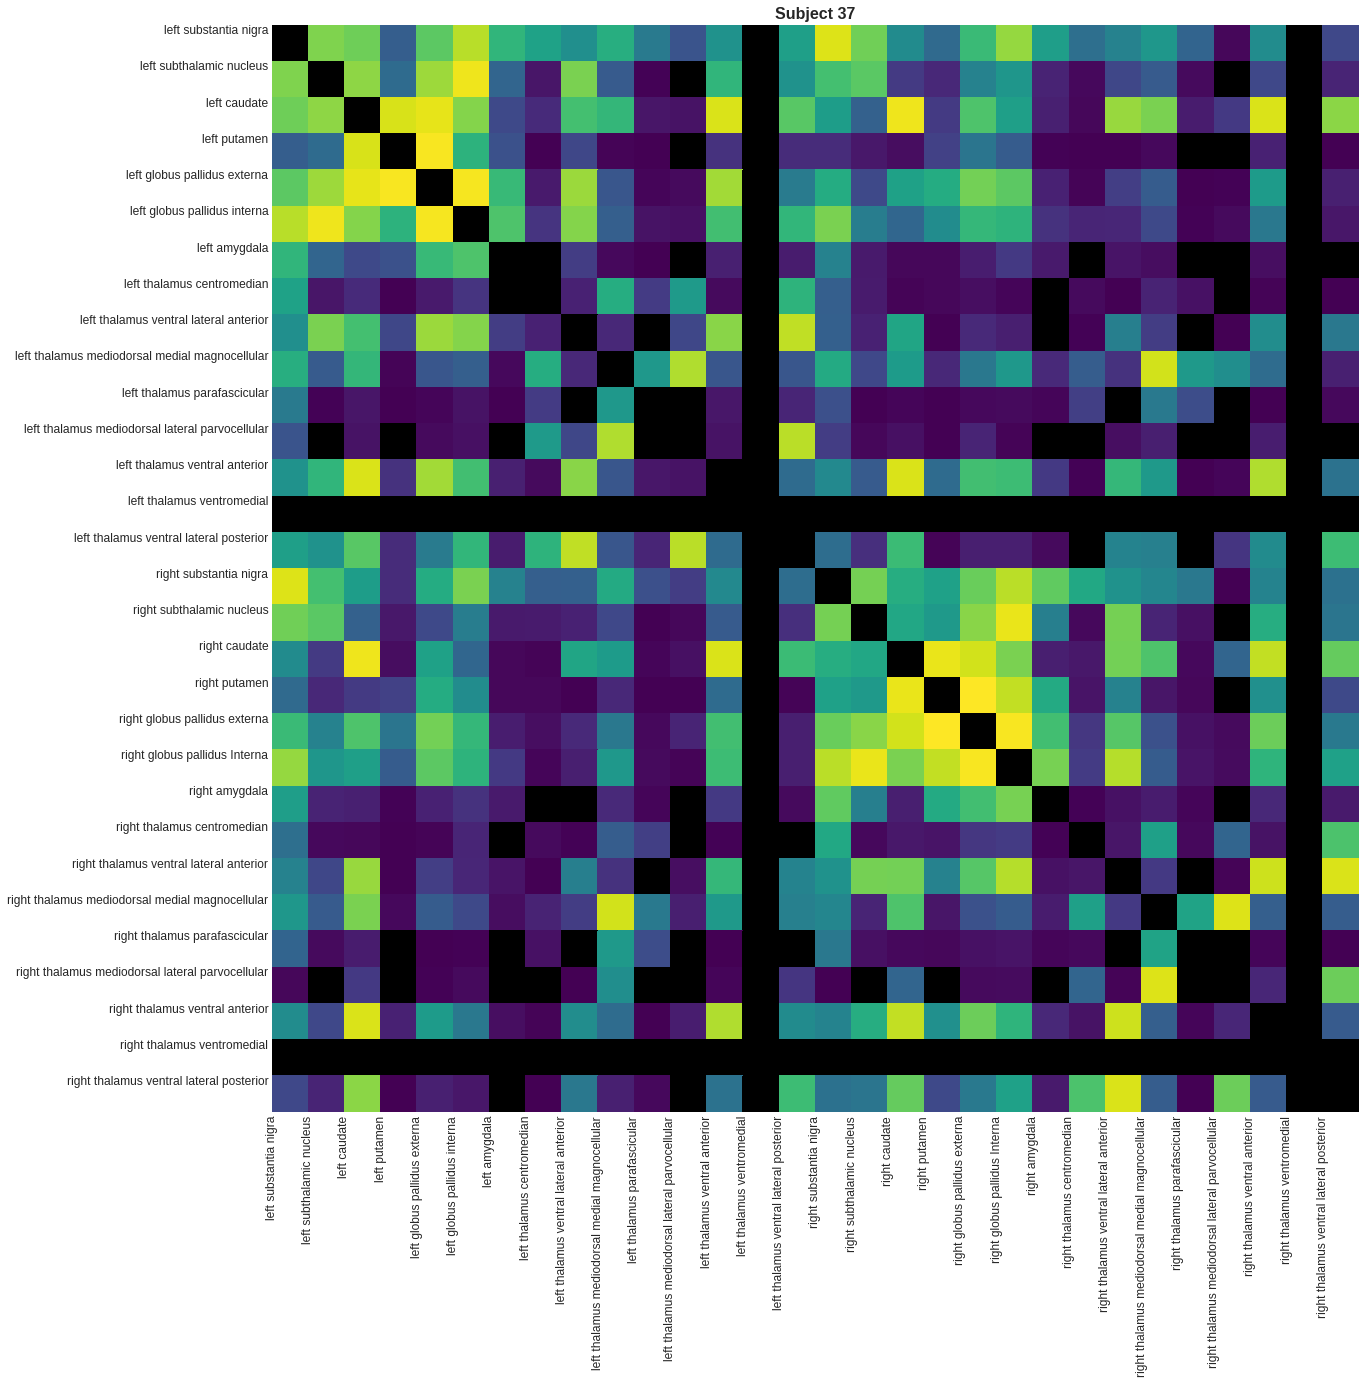

In [7]:
# Plot animation
def update(i):
    df_dsc_subj = pd.DataFrame(dsc_mat[:, :, i])
    df_dsc_subj = df_dsc_subj.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

    # Reorganize dataframe by hemisphere
    df_dsc_subj = df_dsc_subj.reindex(index=reindex_list, columns=reindex_list)

    graph = sns.heatmap(
        df_dsc_subj,
        ax=ax,
        cmap="viridis",
        vmin=0,
        vmax=1,
        square=True,
        cbar=None,
    )

    ax.set_title("Subject {0}".format(i + 1))
    ax.tick_params(axis="both", length=0)
    ax.set_xticks(
        np.arange(len(parcellation_map.reindex(index=reindex_list)["Nuclei"]))
    )
    ax.set_xticklabels(
        parcellation_map.reindex(index=reindex_list)["Nuclei"],
        rotation=90,
        va="top",
        ha="center",
    )
    ax.set_yticks(
        np.arange(len(parcellation_map.reindex(index=reindex_list)["Nuclei"]))
    )
    ax.set_yticklabels(
        parcellation_map.reindex(index=reindex_list)["Nuclei"],
        rotation=0,
        va="top",
        ha="right",
    )


fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# cbar_ax = fig.add_axes([.880, .13, .02, .755])
ani = FuncAnimation(fig, update, frames=dsc_mat.shape[2], interval=200, repeat=True)

HTML(ani.to_html5_video())

In [9]:
plt.close()

In [8]:
# Compute averages
dsc_avg_mat = np.nanmean(dsc_mat, axis=2)
np.fill_diagonal(dsc_avg_mat, np.nan)

dsc_std_mat = np.nanstd(dsc_mat, axis=2)
np.fill_diagonal(dsc_std_mat, np.nan)

df_dsc_avg = pd.DataFrame(dsc_avg_mat)
df_dsc_avg = df_dsc_avg.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

df_dsc_std = pd.DataFrame(dsc_std_mat)
df_dsc_std = df_dsc_std.filter(items=reindex_list, axis=0).filter(items=reindex_list, axis=1)

# Reorganize dataframe by hemisphere
df_dsc_avg = df_dsc_avg.reindex(index=reindex_list, columns=reindex_list)
df_dsc_std = df_dsc_std.reindex(index=reindex_list, columns=reindex_list)

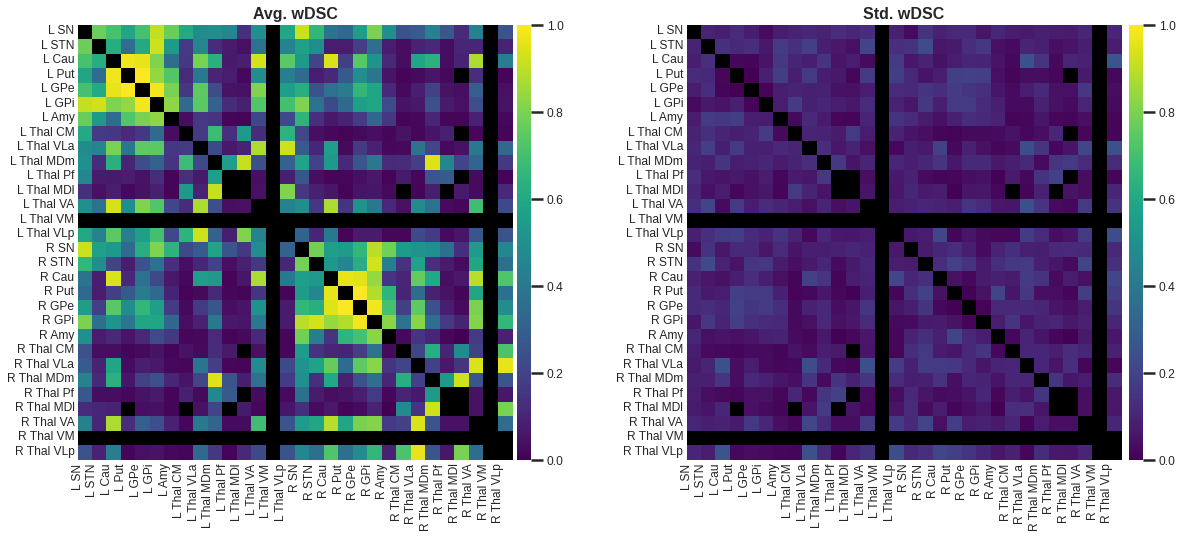

In [10]:
# Plot averages
%matplotlib inline

f, ax = plt.subplots(1, 2, figsize=(20, 8))

# Average
cbar_ax1 = f.add_axes([0.455, 0.125, 0.01, 0.755])
sns.heatmap(
    df_dsc_avg,
    ax=ax[0],
    cmap="viridis",
    vmin=0,
    vmax=1,
    square=True,
    cbar_ax=cbar_ax1,
)
ax[0].set_title("Avg. wDSC")

# Standard Deviation
cbar_ax2 = f.add_axes([0.880, 0.125, 0.01, 0.755])
sns.heatmap(
    df_dsc_std,
    ax=ax[1],
    cmap="viridis",
    vmin=0,
    vmax=1,
    square=True,
    cbar_ax=cbar_ax2,
)
ax[1].set_title("Std. wDSC")

for d in range(2):
    ax[d].tick_params(axis="both", length=0)
    ax[d].set_xticks(
        np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"]))
    )
    ax[d].set_xticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"], va="top", ha="center",
        rotation=90
    )
    ax[d].set_yticks(
        np.arange(len(parcellation_map.reindex(index=reindex_list)["Abbrev"]))
    )
    ax[d].set_yticklabels(
        parcellation_map.reindex(index=reindex_list)["Abbrev"],
        rotation=0,
        va="top",
        ha="right",
    )

filename = "{0}/comparison_streamline_iou.svg".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

In [11]:
# Reorder matrix to grab appropriate labels
df_dsc_avg["Nuclei"] = parcellation_map.reindex(index=reindex_list)["Nuclei"]
df_dsc_avg = df_dsc_avg.sort_values(by=["Nuclei"])
df_dsc_avg = df_dsc_avg.reindex(columns=df_dsc_avg.index.tolist())

# Left
diff_value = df_dsc_avg.iloc[0:15, 0:15].to_numpy()[np.triu_indices(15, k=1)]
hemi = ["Left" for i in range(len(diff_value))]

# Right
diff_R = df_dsc_avg.iloc[15:30, 15:30].to_numpy()[np.triu_indices(15, k=1)]
diff_value = np.append(diff_value, diff_R)
hemi = np.append(hemi, ["Right" for i in range(len(diff_R))])

# Inter
diff_int = df_dsc_avg.iloc[
    0:15, 15:30
] 
diff_int = diff_int.values.flatten()
diff_value = np.append(diff_value, diff_int)

hemi = np.append(hemi, ["Inter" for i in range(len(diff_int))])

# Dataframe
df_dsc_diff = pd.DataFrame({"Value": diff_value, "Hemi": hemi})

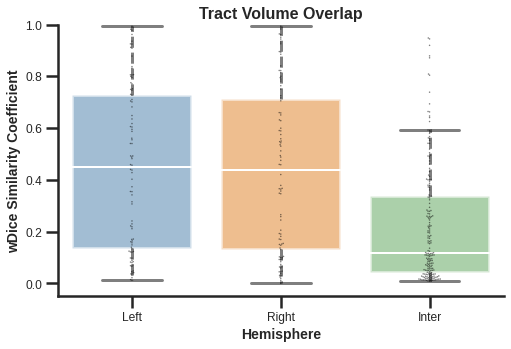

In [13]:
# Plot hemispheric differences
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.boxplot(
    data=df_dsc_diff,
    x="Hemi",
    y="Value",
    hue="Hemi",
    dodge=False,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    showfliers=False,
    whis=0.95,
)
sns.swarmplot(
    data=df_dsc_diff,
    x="Hemi",
    y="Value",
    color="black",
    alpha=0.5,
    dodge=False,
    size=1.5,
)

ax.set_ylim([-0.05, 1])
ax.get_legend().remove()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.title("Tract Volume Overlap")
plt.ylabel("wDice Similarity Coefficient")
plt.xlabel("Hemisphere")

filename = "{0}/comparison_hemi_overlap.png".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

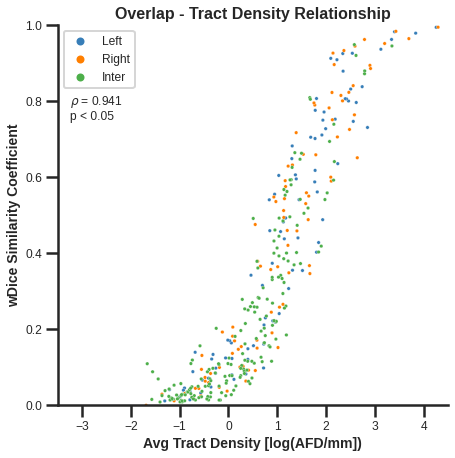

In [14]:
df_test_retest["dsc"] = df_dsc_diff["Value"]

# Plot individual stats (COLORBAR TO BE FIXED)
%matplotlib inline

f, ax = plt.subplots(1, 1, figsize=(7, 7))

df = df_test_retest

sns.scatterplot(data=df, x="Avg", y="dsc", hue="Hemi", ax=ax, s=12)

# Test for normality
stats_sym = "$\\rho$"
pstats = stats.spearmanr(df["Avg"], df["dsc"], nan_policy="omit")

# Legend parms
ax.legend(fontsize=12, markerscale=0.5, loc="upper left")

# Plot params
ax.text(
    -3.25,
    0.75,
    f"""{stats_sym} = {pstats[0]:.3f}
p < 0.05""",
    fontsize=12,
)
ax.set_xlim([-3.5, 4.5])
ax.set_ylim([0, 1])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylabel("wDice Similarity Coefficient")
ax.set_xlabel("Avg Tract Density [log(AFD/mm])")
ax.set_title("Overlap - Tract Density Relationship")

# filename = "{0}/overlap_density_scatter.png".format(figure_dir)
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

#### Thresholding

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.61it/s]


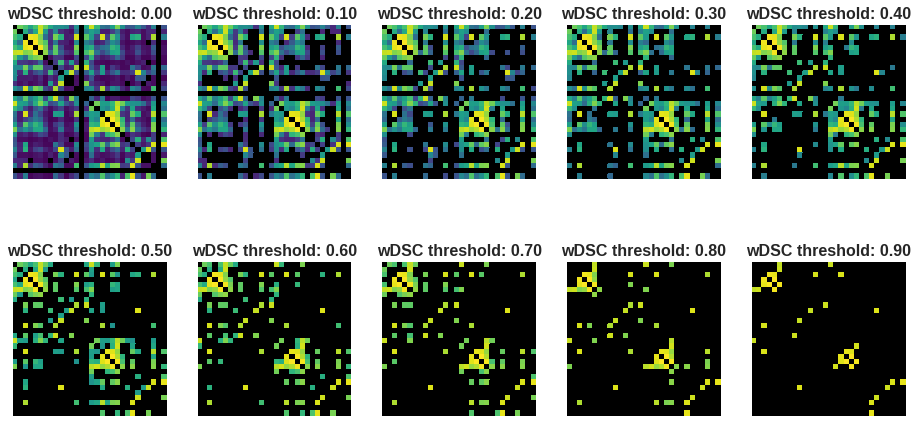

In [15]:
# Avg wDSC at different thresholds
%matplotlib inline 
f, ax = plt.subplots(2,5, figsize=(16,8))

dsc_thresh = np.linspace(0, 1, 11)

df_dsc_avg = df_dsc_avg.reindex(index=reindex_list, columns=reindex_list)

for idx in tqdm(range(10)):
    sns.heatmap(
        df_dsc_avg[df_dsc_avg>=dsc_thresh[idx]],
        ax=ax[idx // 5][idx % 5],
        cmap="viridis",
        vmin=0,
        vmax=1,
        square=True,
        cbar=False
    )

    ax[idx // 5][idx % 5].tick_params(axis="both", length=0)
    ax[idx // 5][idx % 5].set_xticks(
        np.arange(len(parcellation_map.reindex(index=reindex_list)["Nuclei"]))
    )

    ax[idx // 5][idx % 5].set_xticklabels([])
    ax[idx // 5][idx % 5].set_yticks(
        np.arange(len(parcellation_map.reindex(index=reindex_list)["Nuclei"]))
    )

    ax[idx // 5][idx % 5].set_yticklabels([])
    ax[idx // 5][idx % 5].set_title(f"wDSC threshold: {dsc_thresh[idx]:.2f}")

# plt.savefig(f"{figure_dir}/subcortical_thresholds.svg", dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

In [16]:
df_avg = np.nanmean([np.nanmean(test_conn_mat, axis=2), np.nanmean(retest_conn_mat, axis=2)], axis=0)
df_avg = pd.DataFrame(df_avg)

In [17]:
min_density = df_subconn["Avg Density"].describe()["min"]
max_density = df_subconn["Avg Density"].describe()["max"]

density_thresh = np.arange(min_density, max_density, .25)

avg_dsc = []
for idx in tqdm(range(len(density_thresh))):
    dsc_threshed = df_dsc_avg[df_avg >= density_thresh[idx]]
    avg_dsc.append(np.nanmean(dsc_threshed))
    
density_diff = np.diff(density_thresh)
dsc_diff = np.diff(avg_dsc)
rate = dsc_diff / density_diff
rate = np.insert(rate, 0, 0)

NameError: name 'df_subconn' is not defined

NameError: name 'density_thresh' is not defined

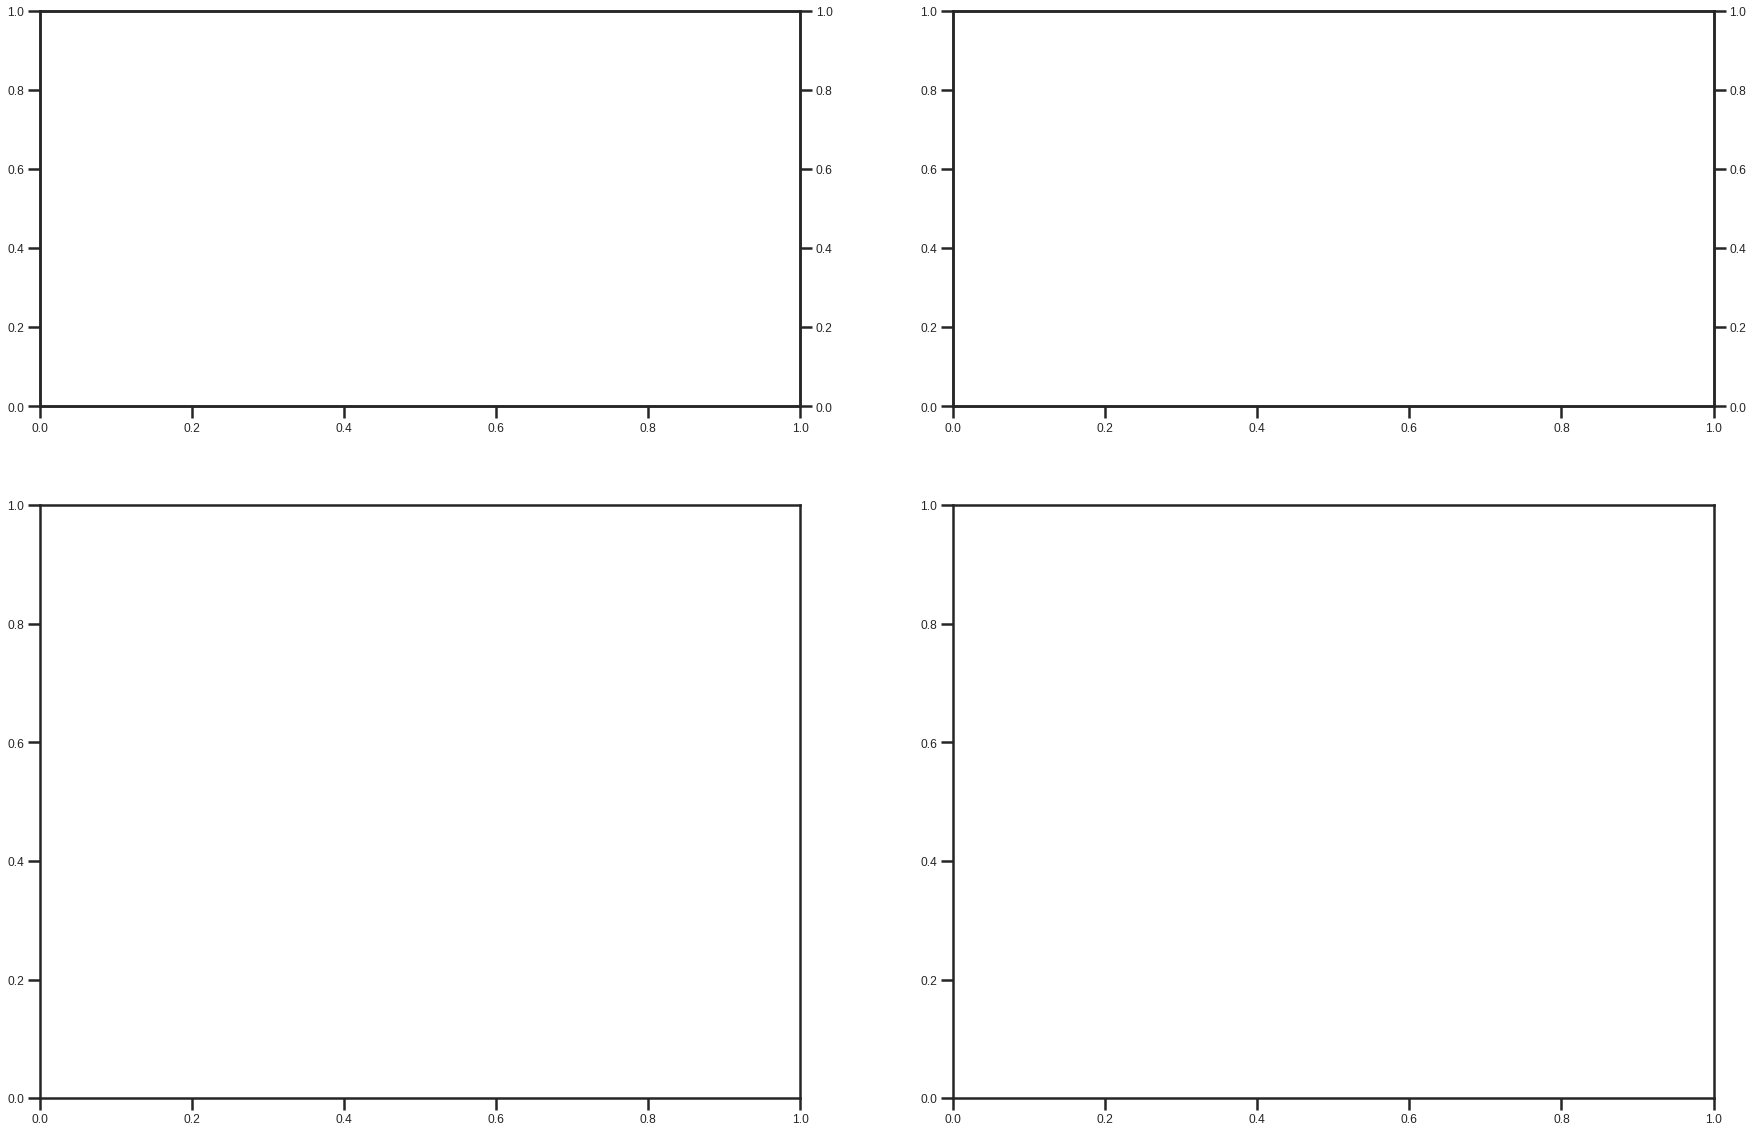

In [18]:
## Connectivity matrix is not arranged correctly, need to fix!!! 

fig, (ax, ax2) = plt.subplots(2,2, figsize=(30, 20), gridspec_kw={"height_ratios": [0.4, 0.6]})
ax0_twin = ax[0].twinx()
ax1_twin = ax[1].twinx()

density_idx = np.argwhere(density_thresh <= 50)[-1][0]
thresh_idx = 25 # Sets density to threshold to 10, where rate of change in overlap is minimum

ax[0].plot(density_thresh, avg_dsc)
ax0_twin.plot(density_thresh, rate, color="r", linestyle="--")
ax[0].set_ylabel("Tract Overlap (wDSC)", color="b")
ax[0].set_xlabel("Tract Density [$AFD/mm^2$]")
ax0_twin.set_ylabel("")
ax[0].set_title("Full Range")
ax[0].set_xlim([0, 20000])
ax[0].set_ylim([0, 1])

ax[1].plot(density_thresh[:density_idx+1], avg_dsc[:density_idx+1])
ax[1].hlines(y=avg_dsc[thresh_idx], xmin=-0, xmax=density_thresh[thresh_idx], linestyle="dotted", color="k")
ax[1].vlines(x=density_thresh[thresh_idx], ymin=0, ymax=avg_dsc[thresh_idx], linestyle="dotted", color="k")
ax[1].scatter(x=density_thresh[thresh_idx], y=avg_dsc[thresh_idx], color="k")
ax1_twin.plot(density_thresh[:density_idx+1], rate[:density_idx+1], color="r", linestyle="--")
ax[1].set_ylabel("")
ax[1].set_xlabel("Tract Density [$AFD/mm^2$]")
ax1_twin.set_ylabel("Overlap Change Rate", color="r")
ax[1].set_xlim([0, 50])
ax[1].set_ylim([0, 0.75])
ax[1].set_title("Low Density")

sns.heatmap(
    df_dsc_avg[df_dsc_avg>=avg_dsc[thresh_idx]],
    ax=ax2[0],
    cmap="viridis",
    vmin=0,
    vmax=1,
    square=True,
    cbar=False
)

ax2[0].tick_params(axis="both", length=0)
ax2[0].set_xticks(
    np.arange(len(parcellation_map.reindex(index=reindex_list)["Nuclei"]))
)
ax2[0].set_xticklabels(
        parcellation_map.reindex(index=reindex_list)["Nuclei"], va="top", ha="left", rotation=90
    )
ax2[0].set_yticks(
    np.arange(len(parcellation_map.reindex(index=reindex_list)["Nuclei"]))
)
ax2[0].set_yticklabels(
        parcellation_map.reindex(index=reindex_list)["Nuclei"], va="top", ha="right", rotation=0
    )
ax2[0].set_title(f"wDSC threshold: {avg_dsc[thresh_idx]:.2f}")

ax2[1].axis("off")

# plt.savefig(f"{figure_dir}/thresholded_connectivity.svg", dpi=300)

plt.show()
plt.close()

In [122]:
# Create a base spreadsheet of connectivity surviving threshold
df_temp = df_subconn.groupby("Nodes").mean()
df_temp = df_temp[df_temp["Tract Overlap (wDSC)"] >= avg_dsc[thresh_idx]]
df_temp = df_temp.reset_index()
df_temp = df_temp[["Nodes", "Node 1 Size [log]", "Node 2 Size [log]"]]
df_temp["Node 1"] = ""
df_temp["Node 2"] = ""
df_temp["Hemi"] = ""
df_temp["Notes"] = ""

for idx, row in df_temp.iterrows():
    node1, node2 = row["Nodes"].split("-")
    
    if check_hemi(int(node1)) == check_hemi(int(node2)):
        df_temp.at[idx, "Hemi"] = "Left" if check_hemi(int(node1)) == "Odd" else "Right"
    else:
        df_temp.at[idx, "Hemi"] = "Inter"
    
    df_temp.at[idx, "Node 1"] = parcellation_map[parcellation_map["Label"] == int(node1)]["Nuclei"].values[0]
    df_temp.at[idx, "Node 2"] = parcellation_map[parcellation_map["Label"] == int(node2)]["Nuclei"].values[0]
    
df_temp.to_csv("hcp1200_3T_TestvRetest_Thresholded.csv", index=False)

#### ROI metrics

In [19]:
subjlist = pd.read_csv(f"{zona_dir}/participants.tsv", header=None)

df_rois = dict()
df_rois["Subject"] = []
df_rois["Label"] = []
df_rois["Size (mm^3)"] = []

for subj in tqdm(demographics_df["Subject"].values):
    subj = f"sub-{subj}"

    # Load segmentations
    # Voxel size -
    subj_rois = nib.load(
        f"{test_dir}/derivatives/zona_bb_subcortex/{subj}/anat/{subj}_space-T1w_desc-ZonaBBSubCorSeg.nii.gz"
    )
    vox_size = subj_rois.header.get_zooms()
    subj_rois = subj_rois.get_fdata()

    for label in parcellation_map["Label"].tolist():
        roi = subj_rois == label
        roi_size = np.round(roi.sum() * vox_size[0] * vox_size[1] * vox_size[2], 3)

        df_rois["Subject"].append(subj)
        df_rois["Label"].append(label)
        df_rois["Size (mm^3)"].append(roi_size)

df_rois = pd.DataFrame(df_rois)
del roi, subj_rois, vox_size

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [01:05<00:00,  1.76s/it]


In [37]:
df_subconn["Node 1 Size"] = np.nan
df_subconn["Node 2 Size"] = np.nan

for idx, row in tqdm(df_subconn.iterrows()):
    df_subconn.at[idx, "Node 1 Size"] = df_rois[
        (df_rois["Subject"] == f'sub-{df_subconn.loc[idx, "Subject"]}')
        & (df_rois["Label"] == int(df_subconn.loc[idx, "Nodes"].split("-")[0]))
    ]["Size (mm^3)"].values[0]
    df_subconn.at[idx, "Node 2 Size"] = df_rois[
        (df_rois["Subject"] == f'sub-{df_subconn.loc[idx, "Subject"]}')
        & (df_rois["Label"] == int(df_subconn.loc[idx, "Nodes"].split("-")[1]))
    ]["Size (mm^3)"].values[0]

df_subconn["Node 1 Size [log]"] = np.log10(df_subconn["Node 1 Size"])
df_subconn["Node 2 Size [log]"] = np.log10(df_subconn["Node 2 Size"])

handle_session(save=True)

16095it [00:26, 605.80it/s]


Saving notebook session


In [38]:
from statsmodels.formula.api import ols

df = df_subconn.copy()
df = df.rename(columns={"Avg Density [log10]":"AvgDensity", "Node 1 Size [log]":"Node1Size", "Node 2 Size [log]":"Node2Size"})

results = ols("AvgDensity ~ Node1Size + Node2Size", data=df.dropna()).fit()
ols_params = results.params

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             AvgDensity   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     1615.
Date:                Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                        09:27:50   Log-Likelihood:                -17137.
No. Observations:               12123   AIC:                         3.428e+04
Df Residuals:                   12120   BIC:                         3.430e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.1212      0.070    -44.751      0.000      -3.258      -2.984
Node1Size      0.6684      0.017     38.860      0.000       0.635       0.702
Node2Size      0.7706      0.018     42.394      0.000       0.735       0.806
==============================================================================
Omnibus:                      189.565   Durbin-Watson:                   0.228
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.012
Skew:                           0.186   Prob(JB):                     1.19e-32
Kurtosis:                       2.609   Cond. No.                         32.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

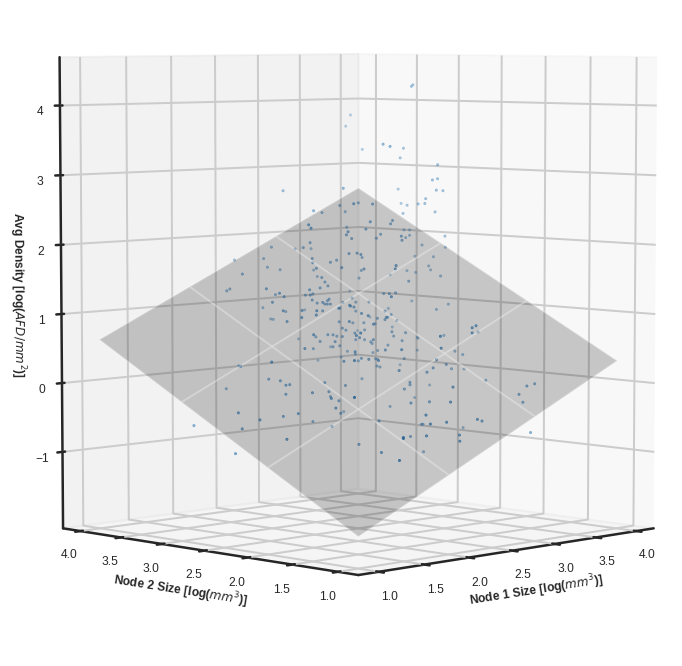

In [8]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fontsize=12

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1, 1, 1, projection="3d")
# ax2 = fig.add_subplot(1, 2, 1)

xx, yy = np.meshgrid(range(1, 5), range(1, 5))
zz = ols_params[0] + xx * ols_params[1] + yy * ols_params[2]

# Get values
x = df_subconn.groupby("Nodes").mean()["Node 1 Size [log]"]
y = df_subconn.groupby("Nodes").mean()["Node 2 Size [log]"]
z = df_subconn.groupby("Nodes").mean()["Avg Density [log10]"]
# Plot
ax1.view_init(5, 225)
ax1.scatter(x, y, z, c=cb_color_cycle[0], s=1)
ax1.plot_surface(xx, yy, zz, alpha=0.2, edgecolor=None, color="black")
ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax1), np.diag([1., 1., 1.5, 1.]))
# Labels
ax1.set_xlabel("Node 1 Size [log($mm^3$)]", fontsize=fontsize)
ax1.set_ylabel("Node 2 Size [log($mm^3$)]", fontsize=fontsize)
ax1.set_zlabel("Avg Density [log($AFD/mm^2$)]", fontsize=fontsize)
ax1.text(0, 0, 6, f"$r^2$ = {results.rsquared_adj:.3f}", fontsize=fontsize)

plt.show()
# plt.close()

In [40]:
plt.close()

#### Motor Circuit (Delong)

In [75]:
# Grab wDSC between motor circuit (Delong) nodes
# 3 (SNr), 5 (STN), 7 (Caudate), 9 (Putamen), 11 (GPe), 13 (GPi), 19 (Amygdala), 
# 35 (ThalCM), 37 (ThalVLa), 41 (ThalMDmc), 43 (ThalPf), 47 (ThalMDpc), 51 (ThalVA), 57 (ThalVM), 69 (ThalVLp)

# Get node names
node_names = ["SN", "STN", "Caudate", "Putamen", "GPe", "GPi", "Amygdala", "Thal CM", "Thal VLa", "Thal MDmc", "Thal Pf", "Thal MDpc", "Thal VA", "Thal VM", "Thal VLp"]
l_node_names = [f"L {node}" for node in node_names]
node_names.reverse()
r_node_names = [f"R {node}" for node in node_names]
final_node_names = l_node_names + r_node_names

# Get connectivity
delong_l_conn = ["3-9", "5-11", "5-13", "9-11", "9-13", "9-35", "9-43", "13-37", "13-57", "13-69"]
delong_r_conn = []
for conn in delong_l_conn:
    idx1, idx2 = conn.split("-")
    delong_r_conn.append(f"{int(idx1)+1}-{int(idx2)+1}")
delong_r_conn.reverse()
delong_conn = delong_l_conn + delong_r_conn
delong_conn_dsc = np.asarray([df_subconn[df_subconn["Nodes"] == node]["Tract Overlap (wDSC)"].replace(-np.inf, np.nan).mean for node in delong_conn])
delong_conn_test = np.asarray([df_subconn[df_subconn["Nodes"] == node]["Test Density [log10]"].replace(-np.inf, np.nan).mean for node in delong_conn])
delong_conn_retest = np.asarray([df_subconn[df_subconn["Nodes"] == node]["Retest Density [log10]"].replace(-np.inf, np.nan).mean for node in delong_conn])

# Map connectivity for chord diagram
delong_conn_l_idx1 = [0, 1, 1, 3, 3, 3, 3, 5, 5, 5] 
delong_conn_l_idx2 = [3, 4, 5, 4, 5, 7, 10, 8, 13, 14]
delong_conn_r_idx1 = [len(final_node_names) - 1 - val for val in delong_conn_l_idx1]; delong_conn_r_idx1.reverse()
delong_conn_r_idx2 = [len(final_node_names) - 1 - val for val in delong_conn_l_idx2]; delong_conn_r_idx2.reverse()
delong_conn_idx1 = delong_conn_l_idx1 + delong_conn_r_idx1
delong_conn_idx2 = delong_conn_l_idx2 + delong_conn_r_idx2

# Create a squared matrix
motor_mat_dsc = np.zeros((len(final_node_names), len(final_node_names)))
motor_mat_test = np.zeros((len(final_node_names), len(final_node_names)))
motor_mat_retest = np.zeros((len(final_node_names), len(final_node_names)))
for idx in range(len(delong_conn_idx1)):
    motor_mat_dsc[delong_conn_idx1[idx], delong_conn_idx2[idx]] = delong_conn_dsc[idx]
    motor_mat_dsc[delong_conn_idx2[idx], delong_conn_idx1[idx]] = delong_conn_dsc[idx]
    
    motor_mat_test[delong_conn_idx1[idx], delong_conn_idx2[idx]] = delong_conn_test[idx]
    motor_mat_test[delong_conn_idx2[idx], delong_conn_idx1[idx]] = delong_conn_test[idx]
    
    motor_mat_retest[delong_conn_idx1[idx], delong_conn_idx2[idx]] = delong_conn_retest[idx]
    motor_mat_retest[delong_conn_idx2[idx], delong_conn_idx1[idx]] = delong_conn_retest[idx]
    
motor_mat_dsc[motor_mat_dsc == 0] = np.nan
motor_mat_test[(motor_mat_test == -np.inf)] = np.nan
motor_mat_test[(motor_mat_test == 0)] = np.nan
motor_mat_retest[(motor_mat_retest == -np.inf)] = np.nan
motor_mat_retest[motor_mat_retest == 0] = np.nan
# motor_mat_dsc[motor_mat_dsc >= avg_dsc[thresh_idx]] = np.nan

#### Associative Circuit

In [83]:
# Grab wDSC between associative circuit nodes
# 3 (SNr), 5 (STN), 7 (Caudate), 9 (Putamen), 11 (GPe), 13 (GPi), 19 (Amygdala), 
# 35 (ThalCM), 37 (ThalVLa), 41 (ThalMDmc), 43 (ThalPf), 47 (ThalMDpc), 51 (ThalVA), 57 (ThalVM), 69 (ThalVLp)

# Get node names
node_names = ["SN", "STN", "Caudate", "Putamen", "GPe", "GPi", "Amygdala", "Thal CM", "Thal VLa", "Thal MDmc", "Thal Pf", "Thal MDpc", "Thal VA", "Thal VM", "Thal VLp"]
l_node_names = [f"L {node}" for node in node_names]
node_names.reverse()
r_node_names = [f"R {node}" for node in node_names]
final_node_names = l_node_names + r_node_names

# Get connectivity
delong_l_conn = ["5-11", "5-13", "7-11", "7-13", "9-11", "11-13", "13-51"]
delong_r_conn = []
for conn in delong_l_conn:
    idx1, idx2 = conn.split("-")
    delong_r_conn.append(f"{int(idx1)+1}-{int(idx2)+1}")
delong_r_conn.reverse()
delong_conn = delong_l_conn + delong_r_conn
delong_conn_dsc = np.asarray([df_subconn[df_subconn["Nodes"] == node]["Tract Overlap (wDSC)"].replace(-np.inf, np.nan).mean() for node in delong_conn])
delong_conn_test = np.asarray([df_subconn[df_subconn["Nodes"] == node]["Test Density [log10]"].replace(-np.inf, np.nan).mean() for node in delong_conn])
delong_conn_retest = np.asarray([df_subconn[df_subconn["Nodes"] == node]["Retest Density [log10]"].replace(-np.inf, np.nan).mean() for node in delong_conn])

# Map connectivity for chord diagram
delong_conn_l_idx1 = [1, 1, 2, 2, 3, 4, 5] 
delong_conn_l_idx2 = [4, 5, 4, 5, 4, 5, 12]
delong_conn_r_idx1 = [len(final_node_names) - 1 - val for val in delong_conn_l_idx1]; delong_conn_r_idx1.reverse()
delong_conn_r_idx2 = [len(final_node_names) - 1 - val for val in delong_conn_l_idx2]; delong_conn_r_idx2.reverse()
delong_conn_idx1 = delong_conn_l_idx1 + delong_conn_r_idx1
delong_conn_idx2 = delong_conn_l_idx2 + delong_conn_r_idx2

# Create a squared matrix
assoc_mat_dsc = np.zeros((len(final_node_names), len(final_node_names)))
assoc_mat_test = np.zeros((len(final_node_names), len(final_node_names)))
assoc_mat_retest = np.zeros((len(final_node_names), len(final_node_names)))
for idx in range(len(delong_conn_idx1)):
    assoc_mat_dsc[delong_conn_idx1[idx], delong_conn_idx2[idx]] = delong_conn_dsc[idx]
    assoc_mat_dsc[delong_conn_idx2[idx], delong_conn_idx1[idx]] = delong_conn_dsc[idx]
    
    assoc_mat_test[delong_conn_idx1[idx], delong_conn_idx2[idx]] = delong_conn_test[idx]
    assoc_mat_test[delong_conn_idx2[idx], delong_conn_idx1[idx]] = delong_conn_test[idx]
    
    assoc_mat_retest[delong_conn_idx1[idx], delong_conn_idx2[idx]] = delong_conn_retest[idx]
    assoc_mat_retest[delong_conn_idx2[idx], delong_conn_idx1[idx]] = delong_conn_retest[idx]
    
assoc_mat_dsc[assoc_mat_dsc == 0] = np.nan
assoc_mat_test[assoc_mat_test == -np.inf] = np.nan
assoc_mat_test[assoc_mat_test == 0] = np.nan
assoc_mat_retest[assoc_mat_retest == -np.inf] = np.nan
assoc_mat_retest[assoc_mat_retest == 0] = np.nan
# assoc_mat_dsc[assoc_mat_dsc >= avg_dsc[thresh_idx]] = np.nan

#### Limbic Circuit

In [94]:
# Grab wDSC between associative circuit (Delong) nodes
# 3 (SNr), 5 (STN), 7 (Caudate), 9 (Putamen), 11 (GPe), 13 (GPi), 19 (Amygdala), 
# 35 (ThalCM), 37 (ThalVLa), 41 (ThalMDmc), 43 (ThalPf), 47 (ThalMDpc), 51 (ThalVA), 57 (ThalVM), 69 (ThalVLp)

# Get node names
node_names = ["SN", "STN", "Caudate", "Putamen", "GPe", "GPi", "Amygdala", "Thal CM", "Thal VLa", "Thal MDmc", "Thal Pf", "Thal MDpc", "Thal VA", "Thal VM", "Thal VLp"]
l_node_names = [f"L {node}" for node in node_names]
node_names.reverse()
r_node_names = [f"R {node}" for node in node_names]
final_node_names = l_node_names + r_node_names

# Get connectivity
delong_l_conn = ["5-11", "5-13", "7-19", "9-13", "9-19", "13-41", "13-47"]
delong_r_conn = []
for conn in delong_l_conn:
    idx1, idx2 = conn.split("-")
    delong_r_conn.append(f"{int(idx1)+1}-{int(idx2)+1}")
delong_r_conn.reverse()
delong_conn = delong_l_conn + delong_r_conn
delong_conn_dsc = np.asarray([df_subconn[df_subconn["Nodes"] == node]["Tract Overlap (wDSC)"].replace(-np.inf, np.nan).mean() for node in delong_conn])
delong_conn_test = np.asarray([df_subconn[df_subconn["Nodes"] == node]["Test Density [log10]"].replace(-np.inf, np.nan).mean() for node in delong_conn])
delong_conn_retest = np.asarray([df_subconn[df_subconn["Nodes"] == node]["Retest Density [log10]"].replace(-np.inf, np.nan).mean() for node in delong_conn])

# Map connectivity for chord diagram
delong_conn_l_idx1 = [1, 1, 2, 3, 3, 5, 5] 
delong_conn_l_idx2 = [4, 5, 6, 5, 6, 9, 11]
delong_conn_r_idx1 = [len(final_node_names) - 1 - val for val in delong_conn_l_idx1]; delong_conn_r_idx1.reverse()
delong_conn_r_idx2 = [len(final_node_names) - 1 - val for val in delong_conn_l_idx2]; delong_conn_r_idx2.reverse()
delong_conn_idx1 = delong_conn_l_idx1 + delong_conn_r_idx1
delong_conn_idx2 = delong_conn_l_idx2 + delong_conn_r_idx2

# Create a squared matrix
limbic_mat_dsc = np.zeros((len(final_node_names), len(final_node_names)))
limbic_mat_test = np.zeros((len(final_node_names), len(final_node_names)))
limbic_mat_retest = np.zeros((len(final_node_names), len(final_node_names)))
for idx in range(len(delong_conn_idx1)):
    limbic_mat_dsc[delong_conn_idx1[idx], delong_conn_idx2[idx]] = delong_conn_dsc[idx]
    limbic_mat_dsc[delong_conn_idx2[idx], delong_conn_idx1[idx]] = delong_conn_dsc[idx]
    
    limbic_mat_test[delong_conn_idx1[idx], delong_conn_idx2[idx]] = delong_conn_test[idx]
    limbic_mat_test[delong_conn_idx2[idx], delong_conn_idx1[idx]] = delong_conn_test[idx]
    
    limbic_mat_retest[delong_conn_idx1[idx], delong_conn_idx2[idx]] = delong_conn_retest[idx]
    limbic_mat_retest[delong_conn_idx2[idx], delong_conn_idx1[idx]] = delong_conn_retest[idx]
    
limbic_mat_dsc[limbic_mat_dsc == 0] = np.nan
limbic_mat_test[limbic_mat_test == 0] = np.nan
limbic_mat_test[limbic_mat_test == -np.inf] = np.nan
limbic_mat_retest[limbic_mat_retest == 0] = np.nan
limbic_mat_retest[limbic_mat_retest == -np.inf] = np.nan
# limbic_mat_dsc[limbic_mat_dsc >= avg_dsc[thresh_idx]] = np.nan

### Figure Creation

#### Figure 2

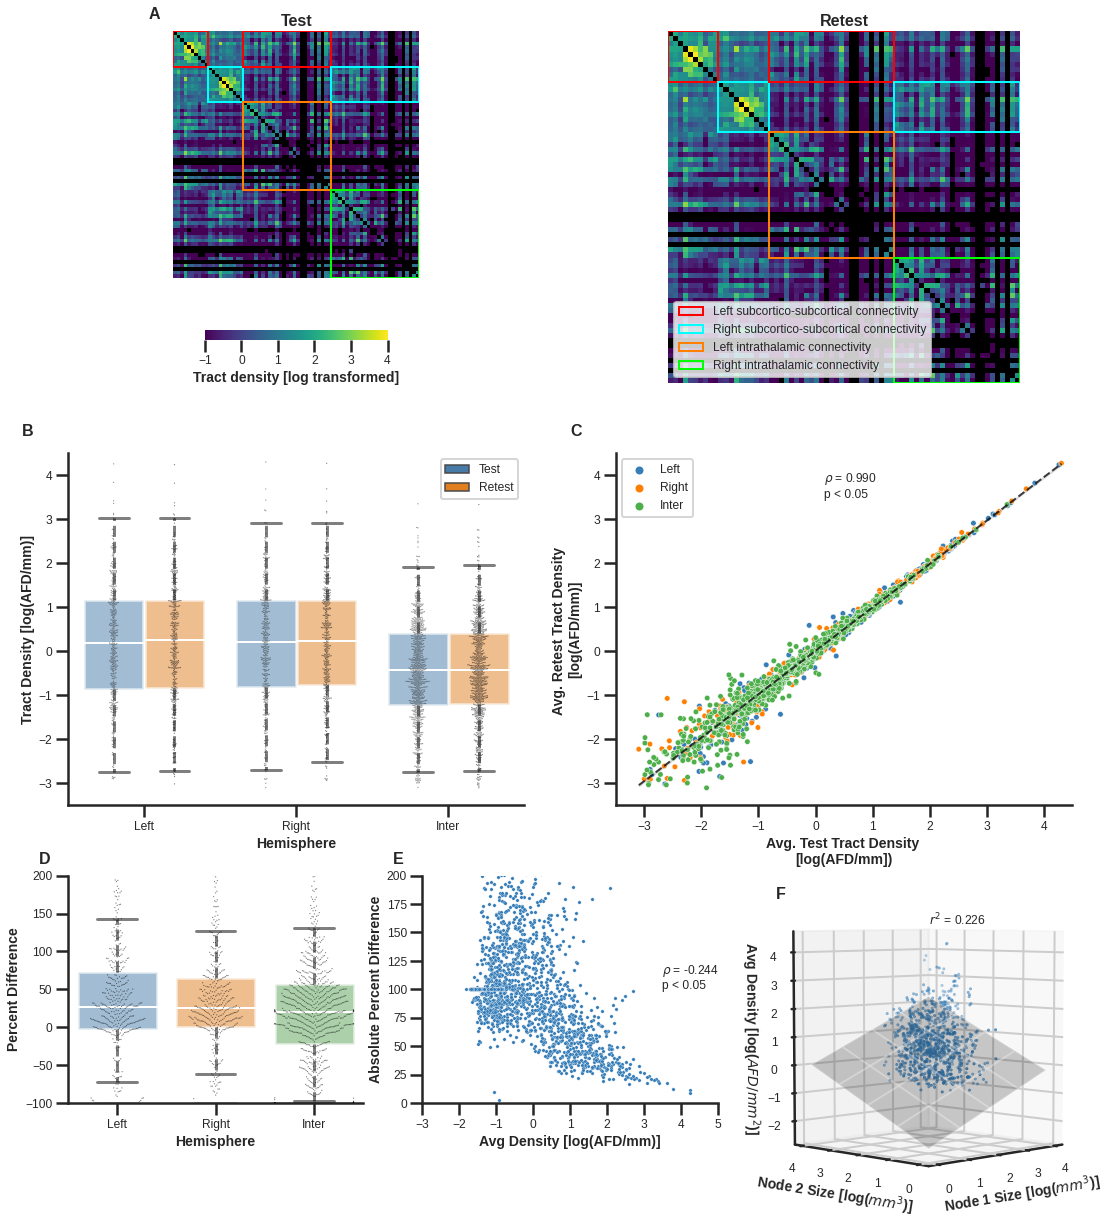

In [48]:
import matplotlib.gridspec as gridspec

%matplotlib inline

fig = plt.figure(figsize=(18, 22))

fontsize = 12
scatsize = 12
boxsize = 1.25

# Main gridspec (3 rows, 1 column)
gs_parent = gridspec.GridSpec(3, 1, figure=fig, hspace=.2)
gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_parent[0])
ax0_left = fig.add_subplot(gs_top[0])
ax0_right = fig.add_subplot(gs_top[1])

# Setup sub gridspec
gs_mid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_parent[1])
ax1 = fig.add_subplot(gs_mid[1])
ax2 = fig.add_subplot(gs_mid[0])

gs_bot = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs_parent[2])
ax3 = fig.add_subplot(gs_bot[:2, 0])
ax4 = fig.add_subplot(gs_bot[:, 2], projection="3d")
ax5 = fig.add_subplot(gs_bot[:2, 1])

# Test / Retest Connectivity matrices - ax0
sns.heatmap(
    np.log10(df_test_avg_subconn),
    ax=ax0_left,
    cmap="viridis",
    vmin=-1,
    vmax=4,
    square=True,
    cbar=True,
    cbar_kws={"orientation": "horizontal", 
              "shrink": 0.4,
              "label": "Tract density [log transformed]"}
)
sns.heatmap(
    np.log10(df_test_avg_subconn),
    ax=ax0_right,
    cmap="viridis",
    vmin=-1,
    vmax=4,
    square=True,
    cbar=False,
)

# Add patches to delineate different connectivity
left_nonthal = ax0_left.add_patch(Rectangle((0, 0), 10, 10,
                    edgecolor="#ff0000",
                    facecolor="none",
                    lw=2))
right_nonthal = ax0_left.add_patch(Rectangle((10, 10), 10, 10,
                   edgecolor="#00ffff",
                   facecolor="none",
                   lw=2))
ax0_left.add_patch(Rectangle((20, 0), 25, 10,
                    edgecolor="#ff0000",
                    facecolor="none",
                    lw=2))
ax0_left.add_patch(Rectangle((45, 10), 25, 10,
                   edgecolor="#00ffff",
                   facecolor="none",
                   lw=2))
left_thal = ax0_left.add_patch(Rectangle((20, 20), 25, 25,
                   edgecolor="#ff8000",
                   facecolor="none",
                   lw=2))
right_thal = ax0_left.add_patch(Rectangle((45, 45), 25, 25,
                   edgecolor="#00ff00",
                   facecolor="none",
                   lw=2))
ax0_right.add_patch(Rectangle((0, 0), 10, 10,
                    edgecolor="#ff0000",
                    facecolor="none",
                    lw=2))
ax0_right.add_patch(Rectangle((10, 10), 10, 10,
                   edgecolor="#00ffff",
                   facecolor="none",
                   lw=2))
ax0_right.add_patch(Rectangle((20, 0), 25, 10,
                    edgecolor="#ff0000",
                    facecolor="none",
                    lw=2))
ax0_right.add_patch(Rectangle((45, 10), 25, 10,
                   edgecolor="#00ffff",
                   facecolor="none",
                   lw=2))
ax0_right.add_patch(Rectangle((20, 20), 25, 25,
                   edgecolor="#ff8000",
                   facecolor="none",
                   lw=2))
ax0_right.add_patch(Rectangle((45, 45), 25, 25,
                   edgecolor="#00ff00",
                   facecolor="none",
                   lw=2))

# Plot params
ax0_left.set_title("Test")
ax0_right.set_title("Retest")
ax0_left.set_yticklabels([]); ax0_left.set_yticks([])
ax0_left.set_xticklabels([]); ax0_left.set_xticks([])
ax0_right.set_yticklabels([]); ax0_right.set_yticks([])
ax0_right.set_xticklabels([]); ax0_right.set_xticks([])
ax0_right.legend([left_nonthal, right_nonthal, left_thal, right_thal], 
                 ["Left subcortico-subcortical connectivity", "Right subcortico-subcortical connectivity", 
                  "Left intrathalamic connectivity", "Right intrathalamic connectivity"])

# Test vs Retest Density - ax1
sns.scatterplot(
    data=df_test_retest, x="Test", y="Retest", hue="Hemi", ax=ax1, s=30, alpha=1
)
sns.regplot(
    data=df_test_retest,
    x="Test",
    y="Retest",
    ax=ax1,
    scatter=False,
    color="black",
    ci=95,
    line_kws={"lw": 2, "linestyle": "--", "alpha": 0.75},
    scatter_kws={"alpha": 0.5, "s": scatsize},
)
pstats = stats.spearmanr(df_test_retest["Test"], df_test_retest["Retest"], nan_policy="omit")

# Plot params
ax1.legend(fontsize=fontsize, markerscale=0.5)
# ax1.get_legend().remove()
ax1.set_xlim([-3.5, 4.5])
ax1.set_ylim([-3.5, 4.5])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylabel("Avg. Retest Tract Density \n[log(AFD/mm)]")
ax1.set_xlabel("Avg. Test Tract Density \n[log(AFD/mm])")
# ax1.set_title(f"Test vs Retest Tract Density")
ax1.text(
    0.15,
    3.5,
    f"""$\\rho$ = {pstats[0]:.3f} 
p < 0.05""",
    fontsize=fontsize,
)

# Plot hemispheric tract density
df = df_test_retest.melt(
    id_vars=["Hemi"],
    value_vars=["Test", "Retest"],
    var_name="Session",
    value_name="Density",
)

sns.boxplot(
    data=df,
    x="Hemi",
    y="Density",
    hue="Session",
    ax=ax2,
    dodge=True,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    showfliers=False,
    whis=0.95,
)

sns.swarmplot(
    data=df,
    x="Hemi",
    y="Density",
    hue="Session",
    ax=ax2,
    color="black",
    alpha=0.5,
    dodge=True,
    size=boxsize,
)

ax2.set_ylim([-3.5, 4.5])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:2], labels[:2])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

# ax2.set_title("Tract Density by Hemisphere")
ax2.set_ylabel("Tract Density [log(AFD/mm)]")
ax2.set_xlabel("Hemisphere")

del df


# Bottom row
# Plot percent change
sns.boxplot(
    data=df_diff,
    x="Hemi",
    y="Value",
    hue="Hemi",
    ax=ax3,
    dodge=False,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    showfliers=False,
    whis=0.95,
)
sns.swarmplot(
    data=df_diff, x="Hemi", y="Value", color="black", ax=ax3, alpha=0.5, dodge=False, size=boxsize
)

ax3.set_ylim([-100, 200])
ax3.get_legend().remove()
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)

ax3.set_title("")
ax3.set_ylabel("Percent Difference")
ax3.set_xlabel("Hemisphere")

# 3D plot of node size vs perc diff
xx, yy = np.meshgrid(range(0, 5), range(0, 5))
zz = ols_params[0] + xx * ols_params[1] + yy * ols_params[2]

# Get values
x = df_subconn.groupby("Nodes").mean()["Node 1 Size [log]"]
y = df_subconn.groupby("Nodes").mean()["Node 2 Size [log]"]
z = df_subconn.groupby("Nodes").mean()["Avg Density [log10]"]
# Plot
ax4.view_init(5, 225)
ax4.scatter(x, y, z, c=cb_color_cycle[0], s=1)
ax4.plot_surface(xx, yy, zz, alpha=0.2, edgecolor=None, color="black")
ax4.get_proj = lambda: np.dot(Axes3D.get_proj(ax4), np.diag([1., 1., 1.5, 1.]))
# Labels
ax4.set_xlabel("Node 1 Size [log($mm^3$)]")
ax4.set_ylabel("Node 2 Size [log($mm^3$)]")
ax4.set_zlabel("Avg Density [log($AFD/mm^2$)]")
ax4.text(0, 0, 5, f"$r^2$ = {results.rsquared_adj:.3f}", fontsize=fontsize)

# Abs perc vs avg density
df = df_subconn.copy()
df["Percent Change"] = np.abs(df["Percent Change"])
df.replace({np.inf: np.nan, -np.inf: np.nan}, inplace=True)

sns.scatterplot(
    x="Avg Density [log10]",
    y="Percent Change",
    data=df.groupby("Nodes").mean(),
    ax=ax5,
    s=scatsize,
)
rho, p = stats.spearmanr(
    df.dropna()["Avg Density [log10]"], df.dropna()["Percent Change"]
)
ax5.set_xlim([-3, 5])
ax5.set_ylim([0, 200])
ax5.set_xlabel("Avg Density [log(AFD/mm)]")
ax5.set_ylabel("Absolute Percent Difference")
ax5.text(
    3.5,
    100,
    f"""$\\rho$ = {rho:.3f}
p < 0.05""",
    fontsize=fontsize,
)
ax5.spines["right"].set_visible(False)
ax5.spines["top"].set_visible(False)

# Add panel labels
axes = [ax0_left, ax2, ax1, ax3, ax5, ax4]
for ix, ax in enumerate(axes):
    if ix != 5:
        ax.text(-0.1, 1.05, s=chr(ord("@")+ix+1), fontsize=16, fontweight="bold", transform=ax.transAxes)
    else:
        ax.text(-0.1, 0, 50, s=chr(ord('@')+ix+1), fontsize=16, fontweight="bold", transform=ax.transAxes)

del df

filename = f"{figure_dir}/fig2_varying_test.svg"
# plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

#### Figure 3

In [ ]:
import matplotlib.gridspec as gridspec

%matplotlib inline

fig = plt.figure(figsize=(12, 4))

fontsize = 12
scatsize = 12
panelsize = 16
boxsize = 1.25

# Main gridspec (1 row(s), 3 column(s))
gs_parent = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[3, 7])
ax1 = fig.add_subplot(gs_parent[0])
ax2 = fig.add_subplot(gs_parent[1])

# ax1 - Hemispheric wDSC
sns.boxplot(
    data=df_dsc_diff,
    x="Hemi",
    y="Value",
    hue="Hemi",
    ax=ax1,
    dodge=False,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    showfliers=False,
    whis=0.95,
)
sns.swarmplot(
    data=df_dsc_diff,
    x="Hemi",
    y="Value",
    ax=ax1,
    color="black",
    alpha=0.5,
    dodge=False,
    size=1.25,
)

ax1.set_ylim([-0.05, 1])
ax1.get_legend().remove()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
# ax1.set_title("Tract Volume Overlap")
ax1.set_ylabel("wDice Similarity Coefficient")
ax1.set_xlabel("Hemisphere")


# ax2 - wDSC vs Avg Density
df = df_test_retest
sns.scatterplot(data=df, x="Avg", y="dsc", hue="Hemi", ax=ax2, s=scatsize, alpha=.75)

# Test for normality
stats_sym = "$\\rho$"
pstats = stats.spearmanr(df["Avg"], df["dsc"], nan_policy="omit")

# Legend parms
ax2.legend(fontsize=fontsize, markerscale=0.5, loc="upper left")

# Plot params
ax2.text(
    -3.25,
    0.45,
    f"""{stats_sym} = {pstats[0]:.3f}
p < 0.05""",
    fontsize=12,
)
ax2.set_xlim([-3.5, 4.5])
ax2.set_ylim([0, 1])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

ax2.set_xlabel("Avg Tract Density [log(AFD/mm])")
ax2.set_ylabel("wDice Similarity Coefficient")
# ax2.set_yticklabels([])
# ax2.set_title("Overlap - Tract Density Relationship")

# Plot panel labels
for ix, ax in enumerate([ax1, ax2]):
    ax.text(-0.1, 1.05, s=chr(ord("@")+ix+1), fontsize=16, fontweight="bold", transform=ax.transAxes)

# Save figure
plt.savefig(f"{figure_dir}/fig3.svg", dpi=300, bbox_inches="tight", facecolor="white")

plt.show()
plt.close()

#### Figure 4
##### Motor circuit

In [ ]:
fig = plt.figure(figsize=(8, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 8])

plot_chord(motor_mat_dsc, final_node_names,
           node_angles=node_angles,
           fig=fig, colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=0, vmax=1, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=1.5)

# fig.savefig(f"{figure_dir}/motor_circuit_dsc.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(8, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 8])

plot_chord(motor_mat_test, final_node_names,
           node_angles=node_angles,
           fig=fig, colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=1.5)

fig.savefig(f"{figure_dir}/motor_circuit_test.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(8, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 8])

plot_chord(motor_mat_retest, final_node_names,
           node_angles=node_angles,
           fig=fig, colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=1.5)

fig.savefig(f"{figure_dir}/motor_circuit_retest.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

##### Associative circuit

In [ ]:
fig = plt.figure(figsize=(8, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 8])

plot_chord(assoc_mat_dsc, final_node_names,
           node_angles=node_angles,
           fig=fig, colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=0, vmax=1, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=1.5)

# fig.savefig(f"{figure_dir}/associative_circuit_dsc.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(8, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 8])

plot_chord(assoc_mat_test, final_node_names,
           node_angles=node_angles,
           fig=fig, colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=1.5)

fig.savefig(f"{figure_dir}/associative_circuit_test.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(8, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 8])

plot_chord(assoc_mat_retest, final_node_names,
           node_angles=node_angles,
           fig=fig, colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=1.5)

fig.savefig(f"{figure_dir}/associative_circuit_retest.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

##### Limbic Circuit

In [ ]:
fig = plt.figure(figsize=(8, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 8])

plot_chord(limbic_mat_dsc, final_node_names,
           node_angles=node_angles,
           fig=fig, colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=0, vmax=1, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=1.5)

# fig.savefig(f"{figure_dir}/limbic_circuit_dsc.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(8, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 8])

plot_chord(limbic_mat_test, final_node_names,
           node_angles=node_angles,
           fig=fig, colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=1.5)

fig.savefig(f"{figure_dir}/limbic_circuit_test.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(8, 8))

node_angles = circular_layout(final_node_names, final_node_names, start_pos=90,
                              group_boundaries=[0, 7, len(final_node_names) / 2, len(final_node_names) / 2 + 8])

plot_chord(limbic_mat_retest, final_node_names,
           node_angles=node_angles,
           fig=fig, colorbar_pos=(-0.3, 0.5), 
           colorbar_size=.5, 
           fontsize_colorbar=12, 
           fontsize_names=12, 
           colormap="viridis",
           vmin=-1, vmax=4, 
           facecolor="white", 
           textcolor="black",
           node_colors=[(0,0,0,0)],
           linewidth=1.5)

fig.savefig(f"{figure_dir}/limbic_circuit_retest.svg", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

## In-depth subcortical nodes <a class="anchor" id="subconn_detail"></a>

* Iterate over subjects and compute regression + corrected p-vals (fdr)
* Create function to plot regression (wDSC vs avg density) + corrected p-vals

In [22]:
df_subconn = dict()
df_subconn["Subject"] = []
df_subconn["Hemi"] = []
df_subconn["Nodes"] = []
df_subconn["Test Density"] = []
df_subconn["Test Density [log10]"] = []
df_subconn["Retest Density"] = []
df_subconn["Retest Density [log10]"] = []
df_subconn["Avg Density"] = []
df_subconn["Avg Density [log10]"] = []
df_subconn["Percent Change"] = []
df_subconn["Tract Overlap (wDSC)"] = []
# df_subconn["ICC"] = []

# Compute for nodes
for idx, (node1, node2) in enumerate(
    tqdm(list(itertools.combinations(parcellation_map["Label"].tolist(), 2)))
):
    nodes = f"{node1}-{node2}"
    # Check for hemi
    if check_hemi(node1) == check_hemi(node2) == "Even":
        hemi = "R"
    elif check_hemi(node1) == check_hemi(node2) == "Odd":
        hemi = "L"
    else:
        hemi = "Inter"

    for s, subj in enumerate(demographics_df["Subject"].tolist()):
        df_subconn["Subject"].append(subj)
        df_subconn["Hemi"].append(hemi)
        df_subconn["Nodes"].append(nodes)

        # Test
        df_test_subj = pd.DataFrame(test_conn_mat[:, :, s])
        test_density = df_test_subj.loc[node1 - 1, node2 - 1]
        df_subconn["Test Density"].append(test_density)
        df_subconn["Test Density [log10]"].append(
            np.log10(df_subconn["Test Density"][-1])
        )

        # Retest
        df_retest_subj = pd.DataFrame(retest_conn_mat[:, :, s])
        retest_density = df_retest_subj.loc[node1 - 1, node2 - 1]
        df_subconn["Retest Density"].append(retest_density)
        df_subconn["Retest Density [log10]"].append(
            np.log10(df_subconn["Retest Density"][-1])
        )

        # Average
        df_subconn["Avg Density"].append(
            np.mean(
                [
                    df_subconn["Test Density"][-1],
                    df_subconn["Retest Density"][-1],
                ]
            )
        )
        df_subconn["Avg Density [log10]"].append(
            np.log10(df_subconn["Avg Density"][-1])
        )

        # Percent change
        df_diff_subj = pd.DataFrame(diff_conn_mat[:, :, s])
        perc_change = df_diff_subj.loc[node1 - 1, node2 - 1]
        df_subconn["Percent Change"].append(perc_change)

        # Overlap
        df_dsc_subj = pd.DataFrame(dsc_mat[:, :, s])
        wDSC = df_dsc_subj.loc[node1 - 1, node2 - 1]
        df_subconn["Tract Overlap (wDSC)"].append(wDSC)


        del (
            df_test_subj,
            df_retest_subj,
            df_diff_subj,
            df_dsc_subj,
            test_density,
            retest_density,
            perc_change,
            wDSC,
        )

    clear_output(wait=True)

df_subconn = pd.DataFrame(df_subconn)

handle_session(save=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:11<00:00, 37.02it/s]


Saving notebook session


In [23]:
# Test intersession
df_subconn_intersession = dict()
df_subconn_intersession["Hemi"] = []
df_subconn_intersession["Nodes"] = []
df_subconn_intersession["t-stat"] = []
df_subconn_intersession["t-pval"] = []
df_subconn_intersession["t-pval (fdr)"] = []
df_subconn_intersession["Density r"] = []
df_subconn_intersession["Density pval"] = []
df_subconn_intersession["Density pval (fdr)"] = []
df_subconn_intersession["wDSC r"] = []
df_subconn_intersession["wDSC pval"] = []
df_subconn_intersession["wDSC pval (fdr)"] = []

for nodes in tqdm(np.unique(df_subconn["Nodes"].tolist())):
    t, t_p = stats.ttest_rel(
        df_subconn[df_subconn["Nodes"] == nodes]["Test Density"],
        df_subconn[df_subconn["Nodes"] == nodes]["Retest Density"],
        nan_policy="omit",
    )
    df_subconn_intersession["Hemi"].append(
        df_subconn[df_subconn["Nodes"] == nodes]["Hemi"].tolist()[0]
    )
    df_subconn_intersession["Nodes"].append(nodes)
    df_subconn_intersession["t-stat"].append(t)
    df_subconn_intersession["t-pval"].append(t_p)

    # Test vs retest regression
    lr, lr_p = stats.spearmanr(
        df_subconn[df_subconn["Nodes"] == nodes]["Test Density"],
        df_subconn[df_subconn["Nodes"] == nodes]["Retest Density"],
    )
    df_subconn_intersession["Density r"].append(lr)
    df_subconn_intersession["Density pval"].append(lr_p)

    # Avg density vs overlap correlation
    try:
        wr, wr_p = stats.spearmanr(
            df_subconn[df_subconn["Nodes"] == nodes]["Avg Density"],
            df_subconn[df_subconn["Nodes"] == nodes]["Tract Overlap (wDSC)"],
        )
        df_subconn_intersession["wDSC r"].append(wr)
        df_subconn_intersession["wDSC pval"].append(wr_p)
    except:
        df_subconn_intersession["wDSC r"].append(np.nan)
        df_subconn_intersession["wDSC pval"].append(np.nan)


# FDR correction
nan_idx = np.argwhere(np.isnan(df_subconn_intersession["t-pval"]))
uncor_pval = np.delete(df_subconn_intersession["t-pval"], nan_idx)
_, cor_pval = fdrcorrection(uncor_pval)
for idx in nan_idx:
    cor_pval = np.insert(cor_pval, idx, np.nan)
df_subconn_intersession["t-pval (fdr)"].extend(cor_pval)

nan_idx = np.argwhere(np.isnan(df_subconn_intersession["Density pval"]))
uncor_pval = np.delete(df_subconn_intersession["Density pval"], nan_idx)
_, cor_pval = fdrcorrection(uncor_pval)
for idx in nan_idx:
    cor_pval = np.insert(cor_pval, idx, np.nan)
df_subconn_intersession["Density pval (fdr)"].extend(cor_pval)

nan_idx = np.argwhere(np.isnan(df_subconn_intersession["wDSC pval"]))
uncor_pval = np.delete(df_subconn_intersession["wDSC pval"], nan_idx)
_, cor_pval = fdrcorrection(uncor_pval)
for idx in nan_idx:
    cor_pval = np.insert(cor_pval, idx, np.nan)
df_subconn_intersession["wDSC pval (fdr)"].extend(cor_pval)

df_subconn_intersession = pd.DataFrame(df_subconn_intersession)

handle_session(save=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:04<00:00, 91.88it/s]


Saving notebook session


In [24]:
# Test rh vs lh - intrasession
df_subconn_intrasession = dict()
df_subconn_intrasession["Nodes"] = []
df_subconn_intrasession["t-stat [Test]"] = []
df_subconn_intrasession["t-pval [Test]"] = []
df_subconn_intrasession["t-pval (fdr) [Test]"] = []
df_subconn_intrasession["t-stat [Retest]"] = []
df_subconn_intrasession["t-pval [Retest]"] = []
df_subconn_intrasession["t-pval (fdr) [Retest]"] = []

tested_nodes = []
for (
    node1,
    node2,
) in tqdm(list(itertools.combinations(parcellation_map["Label"].tolist(), 2))):
    # Ignore interhemispheric connectivity
    if check_hemi(node1) != check_hemi(node2):
        continue

    if check_hemi(node1) == check_hemi(node2) == "even":
        continue

    nodes = f"{node1}-{node2}"
    opp_nodes = f"{node1 + 1}-{node2 + 1}"

    t, p = stats.ttest_ind(
        df_subconn[df_subconn["Nodes"] == nodes]["Test Density"],
        df_subconn[df_subconn["Nodes"] == opp_nodes]["Test Density"],
        nan_policy="omit",
        equal_var=False,
    )
    df_subconn_intrasession["Nodes"].append(nodes)
    df_subconn_intrasession["t-stat [Test]"].append(t)
    df_subconn_intrasession["t-pval [Test]"].append(p)

    t, p = stats.ttest_ind(
        df_subconn[df_subconn["Nodes"] == nodes]["Retest Density"],
        df_subconn[df_subconn["Nodes"] == opp_nodes]["Retest Density"],
        nan_policy="omit",
        equal_var=False,
    )
    df_subconn_intrasession["t-stat [Retest]"].append(t)
    df_subconn_intrasession["t-pval [Retest]"].append(p)

## FDR correction
uncor_pval = [
    df_subconn_intrasession["t-pval [Test]"],
    df_subconn_intrasession["t-pval [Retest]"],
]
uncor_pval = list(itertools.chain(*uncor_pval))
nan_idx = np.argwhere(np.isnan(uncor_pval))
uncor_pval = np.delete(uncor_pval, nan_idx)
_, cor_pval = fdrcorrection(uncor_pval)
for idx in nan_idx:
    cor_pval = np.insert(cor_pval, idx, np.nan)

df_subconn_intrasession["t-pval (fdr) [Test]"].extend(
    cor_pval[: len(df_subconn_intrasession["t-stat [Test]"])]
)
df_subconn_intrasession["t-pval (fdr) [Retest]"].extend(
    cor_pval[len(df_subconn_intrasession["t-stat [Test]"]) :]
)

df_subconn_intrasession = pd.DataFrame(df_subconn_intrasession)

handle_session(save=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:01<00:00, 347.86it/s]


Saving notebook session


In [25]:
df_subconn2 = pd.DataFrame(
    columns=["Subject", "Dataset", "Nodes", "Hemi", "Density", "Density [log]"]
)

for idx, row in tqdm(df_subconn.iterrows()):
    test_data = {
        "Subject": df_subconn.loc[idx, "Subject"],
        "Dataset": "Test",
        "Nodes": df_subconn.loc[idx, "Nodes"],
        "Hemi": df_subconn.loc[idx, "Hemi"],
        "Density": df_subconn.loc[idx, "Test Density"],
        "Density [log]": df_subconn.loc[idx, "Test Density [log10]"],
    }

    retest_data = {
        "Subject": df_subconn.loc[idx, "Subject"],
        "Dataset": "Retest",
        "Nodes": df_subconn.loc[idx, "Nodes"],
        "Hemi": df_subconn.loc[idx, "Hemi"],
        "Density": df_subconn.loc[idx, "Retest Density"],
        "Density [log]": df_subconn.loc[idx, "Retest Density [log10]"],
    }

    df_subconn2 = df_subconn2.append(test_data, ignore_index=True)
    df_subconn2 = df_subconn2.append(retest_data, ignore_index=True)

del test_data, retest_data
handle_session(save=True)

16095it [02:03, 130.46it/s]


Saving notebook session


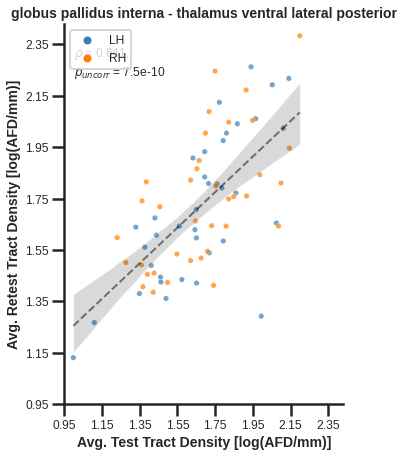

In [36]:
plot_subconn_density_scatter(df_subconn, 13, 69)

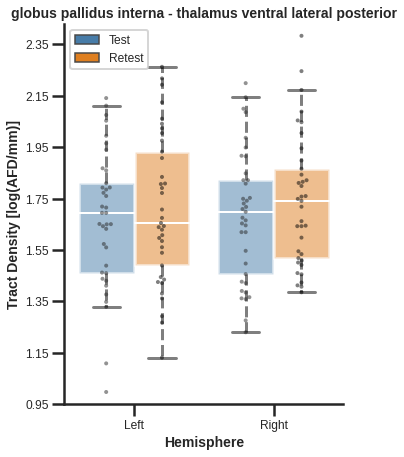

In [27]:
plot_subconn_density_box(df_subconn2, 13, 69)

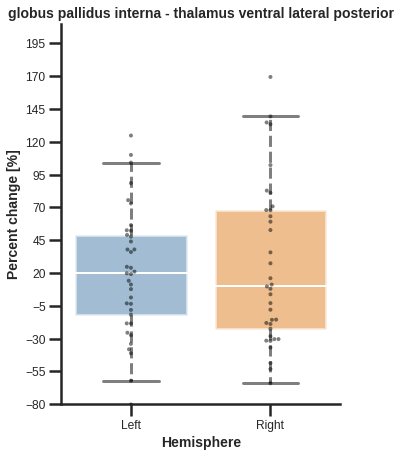

In [28]:
plot_subconn_density_change(df_subconn, 13, 69)

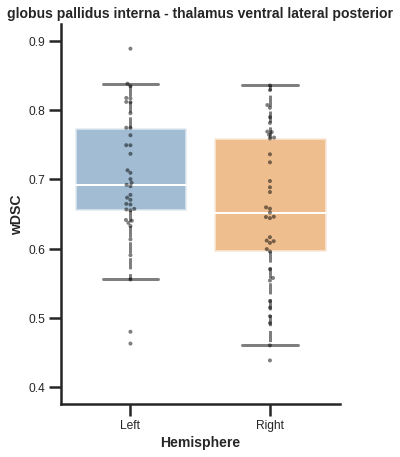

In [29]:
plot_subconn_overlap(df_subconn, 13, 69)

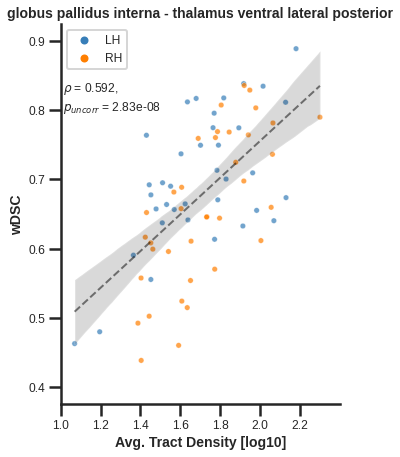

In [30]:
plot_subconn_relationship(df_subconn, 13, 69)

In [33]:
connectivity_summary(13, 69, df_subconn=df_subconn)

Average values for 13-69:
    Test Density 		55.34001265244709
    Retest Density 		63.47388050443417
    Percent Change 		20.635551479377263
    Tract Overlap 		0.7010925468560811

Average values for 14-70:
    Test Density 		56.94616177199862
    Retest Density 		65.88949385552189
    Percent Change 		29.62425851188824
    Tract Overlap 		0.6583907016225763

Intersession tract density (test vs retest): 
    t-stat 			-1.3831420523913631
    Corrected p-val 		0.6384158072456485

Intrasession tract density (lh vs rh):
    Test t-stat 		-0.20521351040512475
    Test corrected p-val 	0.8808613104456546
    Retest t-stat 		-0.2295934345942772
    Retest corrected p-val 	0.8731502100480685


In [201]:
handle_session(save=True)

Saving notebook session


## Installed Packages <a class="anchor" id="installed_pkgs"></a>

In [4]:
import types

import pkg_resources


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package,
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {"PIL": "Pillow", "sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name


imports = list(set(get_imports()))

# Cross-check the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

print("Packages used:")
for r in requirements[::-1]:
    print("{}=={}".format(*r))

Packages used:
dill==0.3.1.1
dipy==1.4.0
fury==0.6.1
joblib==0.11
matplotlib==3.3.4
nibabel==3.2.1
numpy==1.21.2
pandas==1.0.3
pingouin==0.3.4
scipy==1.4.1
seaborn==0.11.0
tqdm==4.56.0
